# DPDIST

In [10]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Proyecto de grado-Extensión/Registro de Nubes/Registro de Nubes')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1bUVmxKZXlCNnu4CbA53Po31b084HWCvL/Registro de Nubes


In [11]:
import os
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt


In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = False
sess3 = tf.InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [13]:
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64')

In [14]:

from tensorflow.python.framework import graph_util
tf.disable_eager_execution()
saver = tf.train.import_meta_graph('./model.ckpt.meta', import_scope='g1', clear_devices=True)
sess3.run(tf.global_variables_initializer())
sess3.run(tf.local_variables_initializer())
saver.restore(sess3, tf.train.latest_checkpoint(os.path.expanduser('./')))

output_node_names = 'g1/pc_compare/output1,g1/pc_compare/output2,g1/gpu_0/total_loss_pred'

# for fixing the bug of batch norm
gd = sess3.graph.as_graph_def()
for node in gd.node:            
    if node.op == 'RefSwitch':
        node.op = 'Switch'
        for index in xrange(len(node.input)):
            if 'moving_' in node.input[index]:
                node.input[index] = node.input[index] + '/read'
    elif node.op == 'AssignSub':
        node.op = 'Sub'
        if 'use_locking' in node.attr: del node.attr['use_locking']
    elif node.op == 'AssignAdd':
        node.op = 'Add'
        if 'use_locking' in node.attr: del node.attr['use_locking']
os.chdir('/content/drive/MyDrive/Proyecto de grado-Extensión/Registro de Nubes/Registro de Nubes')
converted_graph_def = graph_util.convert_variables_to_constants(sess3, gd, output_node_names.split(","))
tf.train.write_graph(converted_graph_def, "./", "FREEZE_DPDIST.pb", as_text=False)

INFO:tensorflow:Restoring parameters from ./model.ckpt


'./FREEZE_DPDIST.pb'

In [15]:
os.chdir('/content/drive/MyDrive/Proyecto de grado-Extensión/Registro de Nubes/Registro de Nubes')
import os
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.framework import graph_util

# DPDIST

def cargar_modelo_congelado(path):
  from tensorflow.python.platform import gfile
  model_path=path

  # read graph definition
  f = gfile.FastGFile(model_path, "rb")
  gd = graph_def = tf.GraphDef()
  graph_def.ParseFromString(f.read())

  # fix nodes
  for node in graph_def.node:
      if node.op == 'RefSwitch':
          node.op = 'Switch'
          for index in xrange(len(node.input)):
              if 'moving_' in node.input[index]:
                  node.input[index] = node.input[index] + '/read'
      elif node.op == 'AssignSub':
          node.op = 'Sub'
          if 'use_locking' in node.attr: del node.attr['use_locking']

  # import graph into session
  with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    tf.train.write_graph(graph_def, './', 'good_frozen.pb', as_text=False)
    tf.train.write_graph(graph_def, './', 'good_frozen.pbtxt', as_text=True)

  return graph

graph = cargar_modelo_congelado("./FREEZE_DPDIST.pb")

def pc_normalize(pc):
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

def crearsession(graph):
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  config.allow_soft_placement = True
  config.log_device_placement = False
  sess = tf.InteractiveSession(config=config, graph=graph)
  return sess

def muestro_resimple(pointCloudA, pointCloudB, num_points=64, num_batches=16):
  #muestreo simple de datos
  pcA = pointCloudA[0:num_points*num_batches, :]
  pcB = pointCloudB[0:num_points*num_batches, :]
    #normalizacion
  pcA = pc_normalize(pcA)
  pcB = pc_normalize(pcB)

  return pcA, pcB


def muestro_resimple2(pointCloudA, pointCloudB, num_points=64, num_batches=16):
  #muestreo simple de datos
  pcA = pointCloudA[0:num_points*num_batches, :]
  pcB = pointCloudB[num_points*num_batches:int((num_points*num_batches)*2), :]
    #normalizacion
  pcA = pc_normalize(pcA)
  pcB = pc_normalize(pcB)

  return pcA, pcB


def crear_inputs(pointCloudA, pointCloudB, num_points, num_batches):

  #inputs
  input1 = pointCloudA.reshape(num_batches, num_points, pointCloudA.shape[1])
  input2 = pointCloudB.reshape(num_batches,  num_points ,pointCloudB.shape[1])
  noise = np.zeros((num_batches, num_points, 3))

  return input1, input2, noise

def DPDist(pointCloudA, pointCloudB, freeze_graph=graph, num_points=64, num_batches=16):

  input_1, input_2, noise = crear_inputs(pointCloudA, pointCloudB, num_points, num_batches)

  sess=crearsession(graph)


  ## NOW the complete graph with values has been restored
  pred_AB = (graph.get_tensor_by_name('g1/pc_compare/output1:0'))
  pred_BA = (graph.get_tensor_by_name('g1/pc_compare/output2:0'))
  loss = (graph.get_tensor_by_name('g1/gpu_0/loss_pred:0'))
  ## Let's feed the images to the input placeholders
  x1= graph.get_tensor_by_name('g1/input1:0')
  x2= graph.get_tensor_by_name('g1/input2:0')
  x3= graph.get_tensor_by_name("g1/add_noise:0")
  #y_test_images = np.zeros((1, 2))
  #sess= tf.Session(graph=graph)
  ### Creating the feed_dict that is required to be fed to calculate y_pred 
  feed_dict_testing = {}
  feed_dict_testing = {x1: input_1, x2: input_2,  x3: noise}
  resultAB =sess.run(pred_AB, feed_dict=feed_dict_testing)
  resultBA=sess.run(pred_BA, feed_dict=feed_dict_testing)

  #DPDist entre nubes
  resultAB_0 = resultAB[:,:,:,:]
  resultBA_0 = resultBA[:,:,:,:]  
  resultAB_0 = resultAB_0.reshape(1024,3)
  resultBA_0 = resultBA_0.reshape(1024,3)
  dist_pcA_pcB=((1/pointCloudA.shape[0])*np.sum(resultAB_0))+((1/pointCloudB.shape[0])*np.sum(resultBA_0))
  
  sess.close()

  return resultAB_0, resultBA_0, dist_pcA_pcB

def plottear_DPDist(DistAB, DistBA, pcA, pcB):
  from matplotlib import pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D

  fig = plt.figure(figsize=(40,15))
  ax = fig.add_subplot(1, 3, 3, projection='3d')

  c = DistAB.reshape(1024)
  c= c[0:512]
  color_map = plt.get_cmap('jet')
  scatter_plot = ax.scatter3D(pcB[0:512,0], pcB[0:512,1], pcB[0:512,2], s=100, c=c, cmap = color_map)
  #scatter_plot2 = ax.scatter3D(pcA1024[:,0], pcA1024[:,1], pcA1024[:,2], c='blue', s=100, cmap = color_map)
  plt.colorbar(scatter_plot)
  
  # Show plot

  plt.show()

##Cargando Modelos del txt



In [16]:
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64')
!pwd

/content/drive/.shortcut-targets-by-id/1asBEAN-S2b77S-W1swprmpEcUXwsqzS3/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64


In [17]:
path = '../../data/modelnet40_normal_resampled' + '/airplane/airplane_00' + str(0)+str(1) + '.txt'
path





'../../data/modelnet40_normal_resampled/airplane/airplane_0001.txt'

In [18]:
def read_pc_by_class(num_point_Clouds, num_points, clase, inicial_path):

  lista = []
  path_i = inicial_path + '/' + clase + '/' + clase +'_'
  
  for i in range(1, num_point_Clouds+1):
    if(i<10):
      path = path_i + '00' + str(0)+str(i) + '.txt'
    if(i>=10 and i<100):
      path = path_i + '00' + str(i) + '.txt'
    if(i>=100 and i<1000):
      path = path_i + '0' + str(i) + '.txt'
    if(i>=1000):
      path = path_i + str(i) + '.txt'
    pC = np.loadtxt(path, delimiter=',', usecols=(0,1,2))
    pC = pC[:num_points, :]
    lista.append(pC)



  return lista


In [19]:
def dpdist2dataframe(pcA, pcB, DistAB, DistBA):
  import pandas as pd
  datos = {'n_punto_pcA':range(pcA.shape[0]), 'Superficie_sB': range(pcB.shape[0]), 'DPDistAB': DistAB}
  datos2 = {'n_punto_pcB':range(pcB.shape[0]), 'Superficie_sA': range(pcA.shape[0]), 'DPDistBA': DistBA}
  d = pd.DataFrame(datos)
  d2 = pd.DataFrame(datos2)
  return d, d2

In [20]:
def similares_diferentes(dataset1, dataset2, rango, pcA, pcB):
  
  m = dataset1
  m2= dataset2
  rango=rango
  similares=[]
  diferentes=[]
  sim = []
  dif = []
  
  for i in range(len(m['DPDistAB'])):
    if(m['DPDistAB'][i]<=rango):
      similares.append(m['n_punto_pcA'][i])
      sim.append(pcB[i])
    else:
      diferentes.append(m['n_punto_pcA'][i])
      dif.append(pcB[i])


  similares2=[]
  diferentes2=[]
  sim2 = []
  dif2 = []

  for i in range(len(m2['DPDistBA'])):
    if(m2['DPDistBA'][i]<=rango):
      similares2.append(m2['n_punto_pcB'][i])
      sim2.append(pcA[i])
    else:
      diferentes2.append(m2['n_punto_pcB'][i])
      dif2.append(pcA[i])
  
  similaresAB=similares
  diferentesAB=diferentes
  similaresBA=similares2
  diferentesBA=diferentes2

  simAB=sim
  difAB=dif
  simBA=sim2
  difBA=dif2

  return similaresAB, diferentesAB, similaresBA, diferentesBA, simAB, difAB, simBA, difBA 

In [21]:
def p_coincidentes_PcAyPcB(similaresAB, similaresBA):
  coincidentes=[]
  similares = similaresAB
  similares2 = similaresBA
  if len(similares)<len(similares2):
    for i in range(len(similares)):
      for j in range(len(similares)):
        if(similares[i]==similares2[j]):
          coincidentes.append(similares[i])
  else:
    for i in range(len(similares2)):
      for j in range(len(similares2)):
        if(similares2[i]==similares[j]):
          coincidentes.append(similares2[i])
  
  return coincidentes

In [22]:
def distanciaEuclideana(pcA, pcB, posiciones_coincidentes):
  from scipy.spatial import distance

  pcAsim = []
  pcBsim = []
  for i in range(len(posiciones_coincidentes)):
    for j in range(len(pcA)):
      if(j==posiciones_coincidentes[i]):
        pcBsim.append(pcB[j])
        pcAsim.append(pcA[j])
  
  pcAnueva = np.array(pcAsim)
  pcBnueva = np.array(pcBsim)

  ematrix=np.ones((pcAnueva.shape[0],pcAnueva.shape[0]))
  for i in range(len(pcAnueva)):
    for j in range(len(pcBnueva)):
      dst = distance.euclidean(pcAnueva[i], pcBnueva[j])
      ematrix[i][j]=dst

  return pcAnueva, pcBnueva, ematrix

In [23]:
def diagonalP_zeros(euclidean_matrix):
  ematrixd_zeros=np.copy(euclidean_matrix)
  np.fill_diagonal(ematrixd_zeros, 0.0)

  return ematrixd_zeros

In [24]:
def euclidean_algorithm_data(pcList):
  import tensorflow.compat.v1 as tf
  ematrix_l=[]
  ematrixd_zeros_l=[]
  ematrix_list=[]
  ematrixd_zeros_list=[]
  pcAnueva_list=[]
  pcBnueva_list=[]
  for i in range(len(pcList)):
    for j in range(len(pcList)):
      if(j==i):
        pcA = pcList[i]
        pcB = pcList[j]
        DistAB, DistBA, DPDistAB=DPDist(pcA, pcB) 
        dataAB, dataBA = dpdist2dataframe(pcA, pcB, DistAB, DistBA)
        similaresAB, diferentesAB, similaresBA, diferentesBA, simAB, difAB, simBA, difBA = similares_diferentes(dataAB, dataBA, 0.15, pcA, pcB)
        coincidentes = p_coincidentes_PcAyPcB(similaresAB, similaresBA)
        pcAnueva, pcBnueva, ematrix= distanciaEuclideana(pcA, pcB, coincidentes)
        ematrixd_zeros =diagonalP_zeros(ematrix)
        pcAnueva_list.append(pcAnueva)
        pcBnueva_list.append(pcBnueva)
        ematrix_l.append(ematrix)
        ematrixd_zeros_l.append(ematrixd_zeros)

  l = []
  for k in range(len(ematrix_l)):
    l.append(ematrix_l[k].shape[0])
  minimo = min(l)
  for ii in range(len(ematrix_l)):
    ematrix_list.append(ematrix_l[ii][:minimo, :minimo])
    ematrixd_zeros_list.append(ematrixd_zeros_l[ii][:minimo, :minimo])

  return pcAnueva_list, pcBnueva_list, ematrix_list, ematrixd_zeros_list
      

In [25]:
import tensorflow.compat.v1 as tf

In [26]:
os.chdir('/content/drive/MyDrive/Proyecto de grado-Extensión/Registro de Nubes/data/')
!pwd

/content/drive/.shortcut-targets-by-id/1xABKCq28x5eFPW5f_7jxdnPcPcDgSzjP/Proyecto de grado-Extensión/Registro de Nubes/data


#DATA

In [27]:
data1 = np.loadtxt('Angelematrix_list_data256.txt', delimiter=',')
data2 = np.loadtxt('ematrix_list_data256.txt', delimiter=',')

In [28]:
data3 = np.loadtxt('ematrix_list_data2_100.txt', delimiter=',')
data4 = np.loadtxt('2ematrix_list_data256.txt', delimiter=',')




In [29]:
data1 = data1.reshape(data1.shape[0], 256, 256)
data2 = data2.reshape(data2.shape[0], 256, 256)
data3 = data3.reshape(data3.shape[0], 256, 256)
data4 = data4.reshape(data4.shape[0], 256, 256)

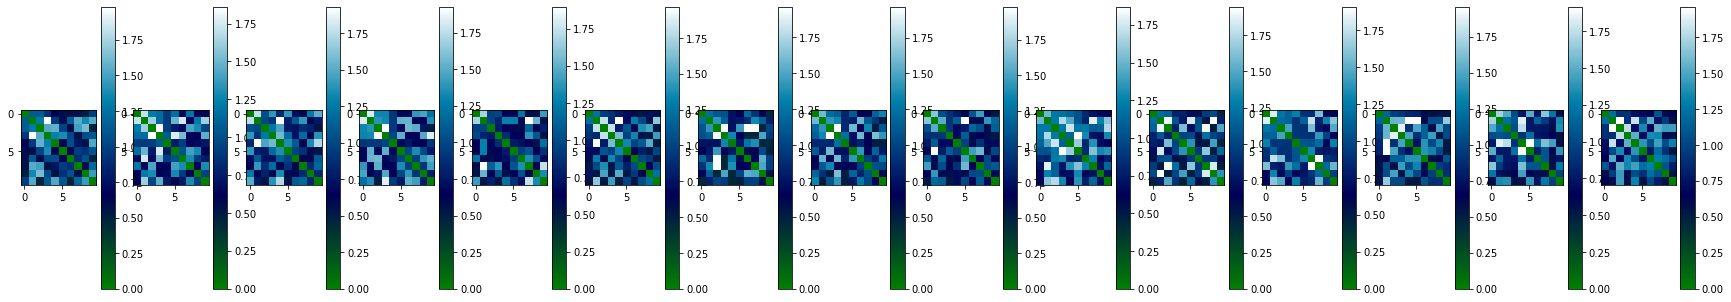

In [30]:
fig = plt.figure(figsize=(30,15))
for i in range(15):
  ax = fig.add_subplot(1,15,i+1)
  ax.set_aspect('equal')
  plt.imshow(data4[i][:10,:10], cmap=plt.cm.ocean)
  plt.colorbar()
plt.show()

In [31]:
data3.shape

(600, 256, 256)

In [32]:
ematrixs = np.concatenate((data1, data2, data3, data4), axis=0)

In [33]:
ematrixs = ematrixs
ematrixs.shape

(4136, 256, 256)

In [34]:

ematrix_list_new =  [0] * len(ematrixs)
for i in range(len(ematrixs)):
  ematrix_list_new[i]=ematrixs[i][0:28,0:28]


In [35]:
X = np.array(ematrix_list_new)
print(X.shape)

(4136, 28, 28)


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2)

In [37]:
X_train.shape

(3308, 28, 28)

In [38]:
X_test.shape

(828, 28, 28)

In [39]:
X_train = X_train.astype('float32') / np.max(X_train)
X_test = X_test.astype('float32') / np.max(X_test)


In [40]:
x_train_d = np.expand_dims(X_train, axis=3)
x_test_d = np.expand_dims(X_test, axis=3)
print("one sample: ", x_train_d[0].shape)
print(x_train_d.shape)

one sample:  (28, 28, 1)
(3308, 28, 28, 1)


In [41]:
x_train_flatten = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
x_test_flatten = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
#y_train_flatten = Y_train.reshape(len(Y_train), np.prod(Y_train.shape[1:]))
#y_test_flatten = Y_test.reshape(len(Y_test), np.prod(Y_test.shape[1:]))
print(x_train_flatten.shape)
#print(y_train_flatten.shape)

(3308, 784)


# Autoencoder 2 dimensiones con activación sigmoide

In [77]:
encoding_dimension = 12
input_img = tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2]))
encoded = tf.keras.layers.Dense(64, activation='relu')(input_img)
#encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(encoding_dimension, activation='relu')(encoded)
#decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(X_train.shape[1],activation='sigmoid')(decoded)
autoencoder1 = tf.keras.models.Model(input_img, decoded)
autoencoder1.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 dense_36 (Dense)            (None, 28, 64)            1856      
                                                                 
 dense_37 (Dense)            (None, 28, 12)            780       
                                                                 
 dense_38 (Dense)            (None, 28, 64)            832       
                                                                 
 dense_39 (Dense)            (None, 28, 28)            1820      
                                                                 
Total params: 5,288
Trainable params: 5,288
Non-trainable params: 0
_________________________________________________________________


In [78]:
import tensorflow as tf

In [79]:
opt = tf.optimizers.Adam(learning_rate = 0.01)
autoencoder1.compile(optimizer=opt, loss='binary_crossentropy')
hist = autoencoder1.fit(X_train, X_train, epochs=50,
                batch_size=256, 
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 3308 samples, validate on 828 samples
Epoch 1/50
3308/3308 [==============================] - ETA: 0s - loss: 0.6852

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3308/3308 [==============================] - 1s 377us/sample - loss: 0.6852 - val_loss: 0.6752
Epoch 2/50
3308/3308 [==============================] - 0s 141us/sample - loss: 0.6690 - val_loss: 0.6592
Epoch 3/50
3308/3308 [==============================] - 0s 142us/sample - loss: 0.6569 - val_loss: 0.6511
Epoch 4/50
3308/3308 [==============================] - 0s 114us/sample - loss: 0.6522 - val_loss: 0.6474
Epoch 5/50
3308/3308 [==============================] - 0s 114us/sample - loss: 0.6480 - val_loss: 0.6440
Epoch 6/50
3308/3308 [==============================] - 0s 120us/sample - loss: 0.6455 - val_loss: 0.6425
Epoch 7/50
3308/3308 [==============================] - 0s 120us/sample - loss: 0.6445 - val_loss: 0.6422
Epoch 8/50
3308/3308 [==============================] - 0s 144us/sample - loss: 0.6442 - val_loss: 0.6413
Epoch 9/50
3308/3308 [==============================] - 0s 138us/sample - loss: 0.6436 - val_loss: 0.6412
Epoch 10/50
3308/3308 [==============================] - 

In [80]:
autoencoder1.layers[-3:]

In [81]:

# Encoder
encoder1 = tf.keras.models.Model(input_img, encoded)

'''
#Decoder
encoded_input = tf.keras.layers.Input(shape=(256,encoding_dimension))
decoder_layer = autoencoder.layers[-3:]
decoder = tf.keras.models.Model(encoded_input, decoder_layer[encoding_dimension])

print("\n encoder model: encoder \n")
print(encoder.summary())
print(" \n decoder model: decoder \n")
print(decoder.summary())
'''

'\n#Decoder\nencoded_input = tf.keras.layers.Input(shape=(256,encoding_dimension))\ndecoder_layer = autoencoder.layers[-3:]\ndecoder = tf.keras.models.Model(encoded_input, decoder_layer[encoding_dimension])\n\nprint("\n encoder model: encoder \n")\nprint(encoder.summary())\nprint(" \n decoder model: decoder \n")\nprint(decoder.summary())\n'

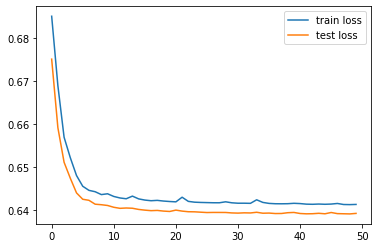

In [82]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

In [83]:
encoded_imgs1 = encoder1.predict(X_test)
predicted1 = autoencoder1.predict(X_test)
predicted1.shape

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(828, 28, 28)

In [84]:
X_test[2].shape

(28, 28)

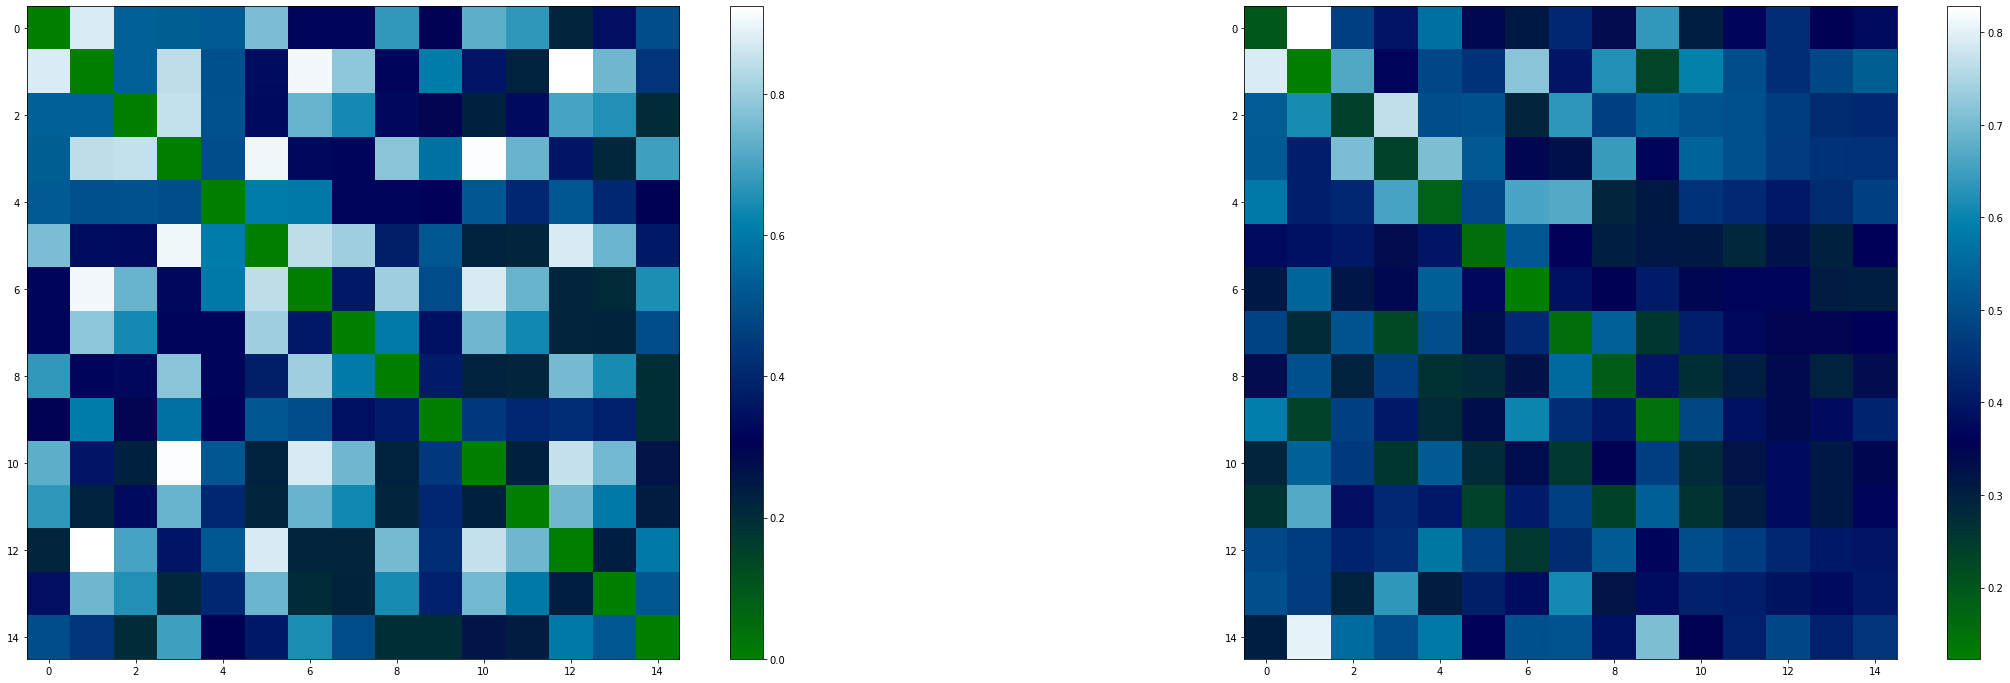

In [85]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
plt.imshow(X_test[2][0:15,0:15], cmap=plt.cm.ocean)
plt.colorbar()

ax = fig.add_subplot(1,2,2)
ax.set_aspect('equal')
plt.imshow(predicted1[3][0:15,0:15], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [51]:
encoded_imgs1.shape

(828, 28, 12)

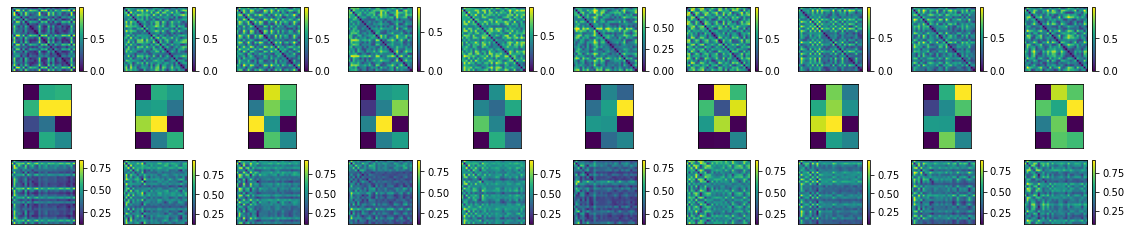

In [53]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_flatten[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs1[i][i].reshape(4,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted1[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [87]:
np.mean(X_test[2])

0.45985544

In [88]:
np.mean(predicted1[2])

0.46577272

## Prueba

In [224]:
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64')
!pwd

/content/drive/.shortcut-targets-by-id/1asBEAN-S2b77S-W1swprmpEcUXwsqzS3/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64


In [225]:
chair = read_pc_by_class(2, 1024, 'chair', '../../data/modelnet40_normal_resampled')

In [226]:
def rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta), 0],
                     [np.sin(theta),np.cos(theta), 0],
                     [0,0,1]])

In [227]:
point_cloud_A = chair[0]
Rm = rotation_matrix(np.pi/2)
point_cloud_B= np.dot(Rm, chair[0].T).T


In [228]:
import tensorflow.compat.v1 as tf

In [229]:
DistAB, DistBA, DPDistAB=DPDist(point_cloud_A, point_cloud_B)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [230]:
def dpdist2dataframe(pcA, pcB, DistAB, DistBA):
  import pandas as pd
  datos = {'n_punto_pcA':range(pcA.shape[0]), 'Superficie_sB': range(pcB.shape[0]), 'DPDistAB': DistAB}
  datos2 = {'n_punto_pcB':range(pcB.shape[0]), 'Superficie_sA': range(pcA.shape[0]), 'DPDistBA': DistBA}
  d = pd.DataFrame(datos)
  d2 = pd.DataFrame(datos2)
  return d, d2

In [231]:
dataAB, dataBA = dpdist2dataframe(point_cloud_A, point_cloud_A, DistAB[:,0], DistBA[:,0])

In [232]:
def similares_diferentes(dataset1, dataset2, rango, pcA, pcB):
  
  m = dataset1
  m2= dataset2
  rango=rango
  similares=[]
  diferentes=[]
  sim = []
  dif = []
  
  for i in range(len(m['DPDistAB'])):
    if(m['DPDistAB'][i]<=rango):
      similares.append(m['n_punto_pcA'][i])
      sim.append(pcB[i])
    else:
      diferentes.append(m['n_punto_pcA'][i])
      dif.append(pcB[i])


  similares2=[]
  diferentes2=[]
  sim2 = []
  dif2 = []

  for i in range(len(m2['DPDistBA'])):
    if(m2['DPDistBA'][i]<=rango):
      similares2.append(m2['n_punto_pcB'][i])
      sim2.append(pcA[i])
    else:
      diferentes2.append(m2['n_punto_pcB'][i])
      dif2.append(pcA[i])
  
  similaresAB=similares
  diferentesAB=diferentes
  similaresBA=similares2
  diferentesBA=diferentes2

  simAB=sim
  difAB=dif
  simBA=sim2
  difBA=dif2

  return similaresAB, diferentesAB, similaresBA, diferentesBA, simAB, difAB, simBA, difBA 

In [233]:
similaresAB, diferentesAB, similaresBA, diferentesBA, simAB, difAB, simBA, difBA = similares_diferentes(dataAB, dataBA, 0.15,point_cloud_A,point_cloud_B)

In [234]:
def p_coincidentes_PcAyPcB(similaresAB, similaresBA):
  coincidentes=[]
  similares = similaresAB
  similares2 = similaresBA
  if len(similares)<len(similares2):
    for i in range(len(similares)):
      for j in range(len(similares)):
        if(similares[i]==similares2[j]):
          coincidentes.append(similares[i])
  else:
    for i in range(len(similares2)):
      for j in range(len(similares2)):
        if(similares2[i]==similares[j]):
          coincidentes.append(similares2[i])
  
  return coincidentes

In [235]:
coincidentes = p_coincidentes_PcAyPcB(similaresAB, similaresBA)

In [236]:
def distanciaEuclideana(pcA, pcB, posiciones_coincidentes):
  from scipy.spatial import distance

  pcAsim = []
  pcBsim = []
  for i in range(len(posiciones_coincidentes)):
    for j in range(len(pcA)):
      if(j==posiciones_coincidentes[i]):
        pcBsim.append(pcB[j])
        pcAsim.append(pcA[j])
  
  pcAnueva = np.array(pcAsim)
  pcBnueva = np.array(pcBsim)

  ematrix=np.ones((pcAnueva.shape[0],pcAnueva.shape[0]))
  for i in range(len(pcAnueva)):
    for j in range(len(pcBnueva)):
      dst = distance.euclidean(pcAnueva[i], pcBnueva[j])
      ematrix[i][j]=dst

  return pcAnueva, pcBnueva, ematrix

In [237]:
pcAnueva, pcBnueva, ematrix= distanciaEuclideana(point_cloud_A, point_cloud_B, coincidentes)

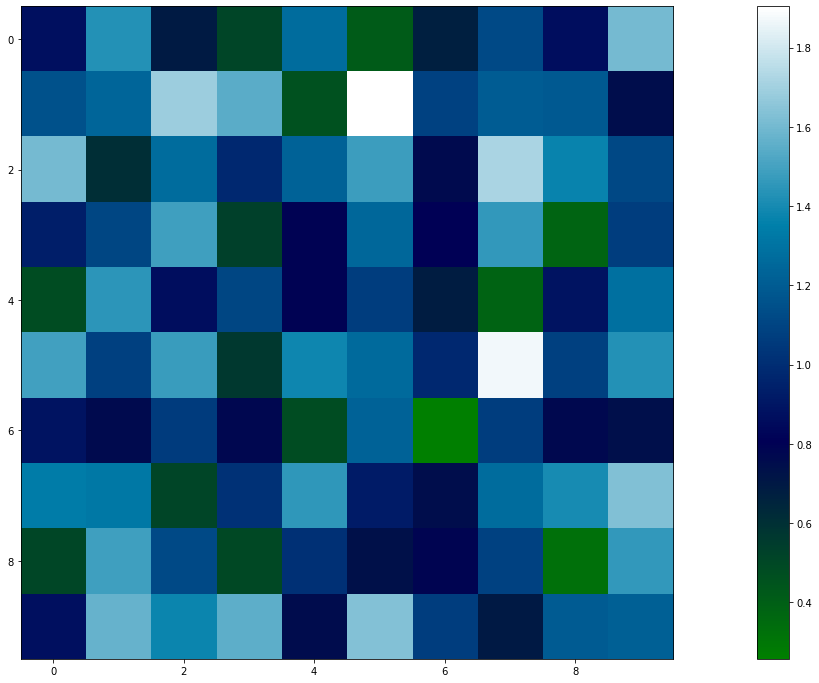

In [238]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(ematrix[:10,:10], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [239]:
ematrixs = ematrix[:28, :28]

In [240]:
ematrixs.shape[0]

28

In [254]:
ematrixflatten = ematrixs.reshape(1, ematrixs.shape[0],ematrixs.shape[1])

In [255]:
ematrixflatten.shape

(1, 28, 28)

In [256]:
bn = encoder1.predict(ematrixflatten)
predicted = autoencoder1.predict(ematrixflatten)
predicted.shape

(1, 28, 28)

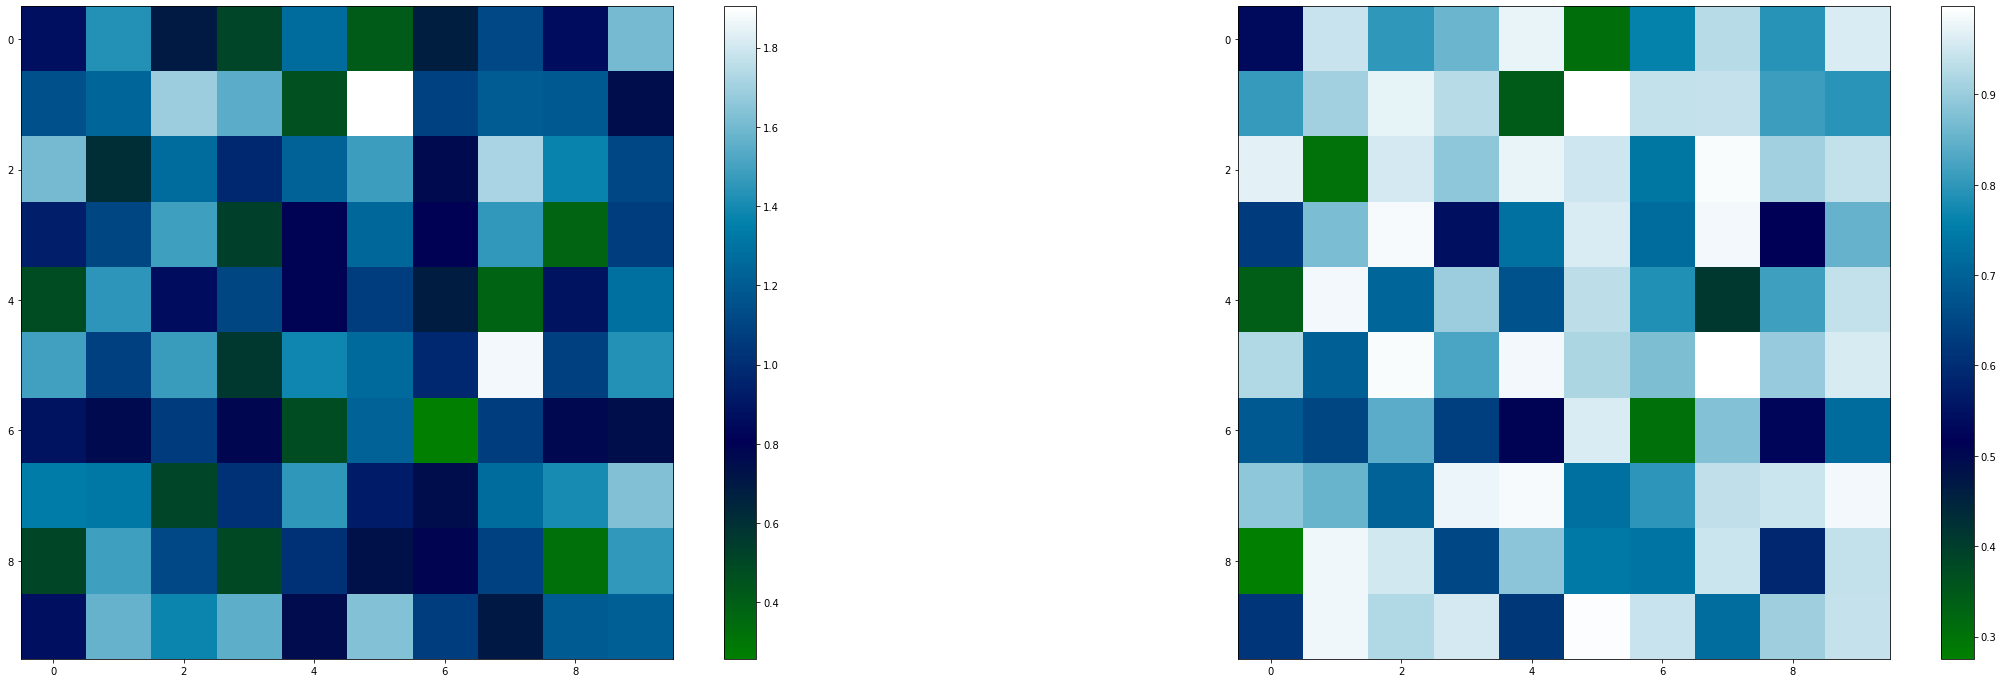

In [257]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
plt.imshow(ematrixflatten.reshape(ematrixs.shape[0],ematrixs.shape[1])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()

ax = fig.add_subplot(1,2,2)
ax.set_aspect('equal')
plt.imshow(predicted.reshape(ematrixs.shape[0],ematrixs.shape[1])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [258]:
pred = predicted.reshape(ematrixs.shape[0],ematrixs.shape[1])

In [260]:
print(bn.shape)

(1, 28, 12)


In [261]:

U, S, Vt = np.linalg.svd(pred) #cualquier transformación puede considerarse como una secuencia de rotación (V * ), escala (S) y rotación de nuevo (U)
R = np.dot(Vt.T, U.T) #matriz de rotación

In [262]:
R.shape

(28, 28)

In [263]:
f = [0,0,0,1]
f = np.array(f)
f.shape

(4,)

In [265]:
bn = bn[:,1].reshape(3,4)
bn.shape

(3, 4)

In [266]:
T = np.vstack([bn, f])

In [267]:
T

array([[0.        , 0.        , 0.        , 0.        ],
       [0.49491715, 2.31471467, 0.        , 4.63393736],
       [2.71758699, 2.77768517, 3.81597733, 1.6996839 ],
       [0.        , 0.        , 0.        , 1.        ]])

In [268]:
Tmp = point_cloud_B[:,:3] + T[3,:3]
Tmp = np.dot(T[:3,:3],Tmp.T).T

In [269]:
Tmp.shape

(1024, 3)

Text(0.5, 0, 'Z')

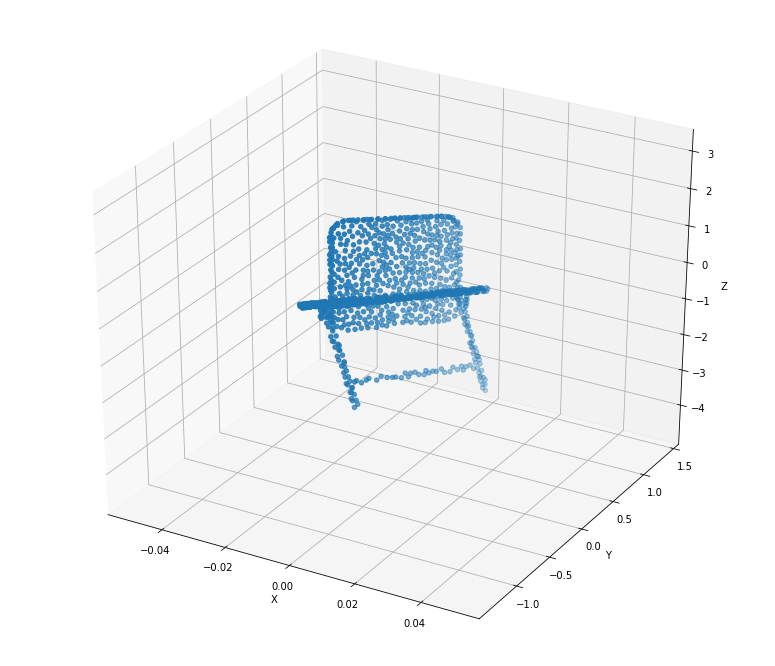

In [270]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = Tmp[:,0]
Y = Tmp[:,1]
Z = Tmp[:,2]
ax.scatter3D(X, Y, -Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

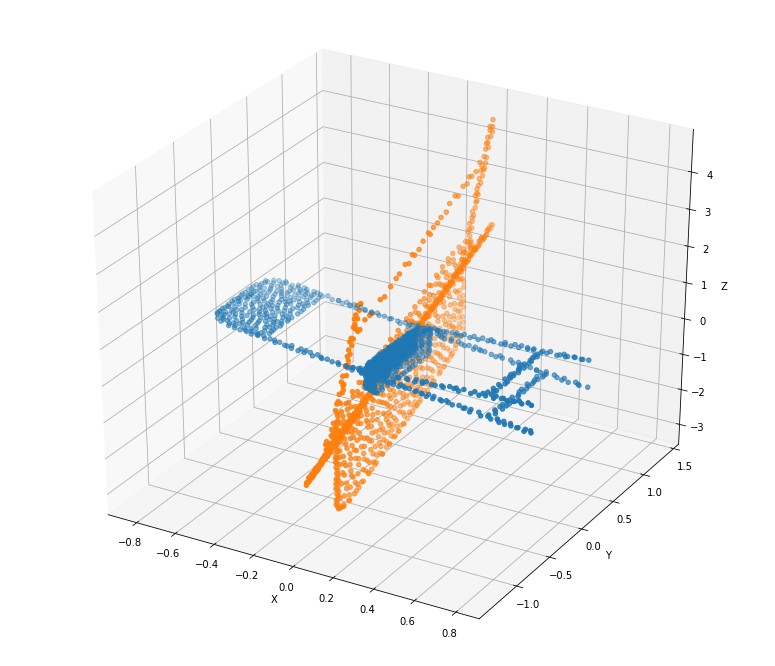

In [271]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloud_B[:,0]
Y = point_cloud_B[:,1]
Z = point_cloud_B[:,2]
ax.scatter3D(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
X = Tmp[:,0]
Y = Tmp[:,1]
Z = Tmp[:,2]
ax.scatter3D(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Autoencoder con 2 dimensiones sin sigmoide

In [ ]:
encoding_dimension = 32
input_img = tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2]))
encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(encoding_dimension, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(X_train.shape[1])(decoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64)]          0         
                                                                 
 dense (Dense)               (None, 64, 1000)          65000     
                                                                 
 dense_1 (Dense)             (None, 64, 1000)          1001000   
                                                                 
 dense_2 (Dense)             (None, 64, 1000)          1001000   
                                                                 
 dense_3 (Dense)             (None, 64, 1000)          1001000   
                                                                 
 dense_4 (Dense)             (None, 64, 1000)          1001000   
                                                                 
 dense_5 (Dense)             (None, 64, 1000)          100100

In [ ]:
import tensorflow as tf

In [ ]:
opt = tf.optimizers.SGD(learning_rate = 0.01)
autoencoder.compile(optimizer=opt, loss='mse')
hist = autoencoder.fit(X_train, X_train, epochs=50,
                batch_size=256, shuffle=True,
                validation_data=(X_test, X_test))

In [ ]:

# Encoder
encoder = tf.keras.models.Model(input_img, encoded)

'''
#Decoder
encoded_input = tf.keras.layers.Input(shape=(256,encoding_dimension))
decoder_layer = autoencoder.layers[-3:]
decoder = tf.keras.models.Model(encoded_input, decoder_layer[encoding_dimension])

print("\n encoder model: encoder \n")
print(encoder.summary())
print(" \n decoder model: decoder \n")
print(decoder.summary())
'''

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

In [ ]:
encoded_imgs = encoder.predict(X_test)
predicted = autoencoder.predict(X_test)
predicted.shape

In [ ]:
X_test[2].shape

In [ ]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
plt.imshow(X_test[2], cmap=plt.cm.ocean)
plt.colorbar()

ax = fig.add_subplot(1,2,2)
ax.set_aspect('equal')
plt.imshow(predicted[2], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [ ]:
encoded_imgs.shape

In [ ]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_flatten[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i][i].reshape(4,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#Autoencoder flatten FUNCIONAL




In [287]:
import tensorflow as tf


In [303]:
encoding_dimension = 12
input_img = tf.keras.layers.Input(shape=(x_train_flatten.shape[1],))
encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
#encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(encoding_dimension, activation='elu')(encoded)
#decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(x_train_flatten.shape[1], activation='sigmoid')(decoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_64 (Dense)            (None, 128)               100480    
                                                                 
 dense_65 (Dense)            (None, 12)                1548      
                                                                 
 dense_66 (Dense)            (None, 128)               1664      
                                                                 
 dense_67 (Dense)            (None, 784)               101136    
                                                                 
Total params: 204,828
Trainable params: 204,828
Non-trainable params: 0
_________________________________________________________________


In [304]:
opt = tf.optimizers.Adamax(learning_rate = 0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
hist = autoencoder.fit(x_train_flatten, x_train_flatten, epochs=50,
                batch_size=12, 
                shuffle=True,
                validation_data=(x_train_flatten, x_train_flatten))

Train on 3308 samples, validate on 3308 samples
Epoch 1/50
3252/3308 [============================>.] - ETA: 0s - loss: 0.6642

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3308/3308 [==============================] - 5s 1ms/sample - loss: 0.6641 - val_loss: 0.6596
Epoch 2/50
3308/3308 [==============================] - 2s 723us/sample - loss: 0.6580 - val_loss: 0.6562
Epoch 3/50
3308/3308 [==============================] - 2s 640us/sample - loss: 0.6553 - val_loss: 0.6543
Epoch 4/50
3308/3308 [==============================] - 2s 726us/sample - loss: 0.6536 - val_loss: 0.6527
Epoch 5/50
3308/3308 [==============================] - 2s 716us/sample - loss: 0.6523 - val_loss: 0.6518
Epoch 6/50
3308/3308 [==============================] - 2s 686us/sample - loss: 0.6514 - val_loss: 0.6509
Epoch 7/50
3308/3308 [==============================] - 3s 776us/sample - loss: 0.6507 - val_loss: 0.6502
Epoch 8/50
3308/3308 [==============================] - 3s 782us/sample - loss: 0.6501 - val_loss: 0.6498
Epoch 9/50
3308/3308 [==============================] - 2s 681us/sample - loss: 0.6498 - val_loss: 0.6497
Epoch 10/50
3308/3308 [==============================] - 2s

In [305]:

# Encoder
encoder = tf.keras.models.Model(input_img, encoded)

'''
#Decoder
encoded_input = tf.keras.layers.Input(shape=(encoding_dimension,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

print("\n encoder model: encoder \n")
print(encoder.summary())
print(" \n decoder model: decoder \n")
print(decoder.summary())
'''

'\n#Decoder\nencoded_input = tf.keras.layers.Input(shape=(encoding_dimension,))\ndecoder_layer = autoencoder.layers[-1]\ndecoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))\n\nprint("\n encoder model: encoder \n")\nprint(encoder.summary())\nprint(" \n decoder model: decoder \n")\nprint(decoder.summary())\n'

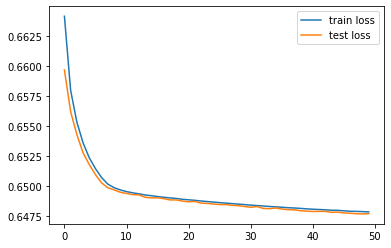

In [306]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

In [307]:
encoded_imgs = encoder.predict(x_test_flatten)
predicted = autoencoder.predict(x_test_flatten)
predicted.shape

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(828, 784)

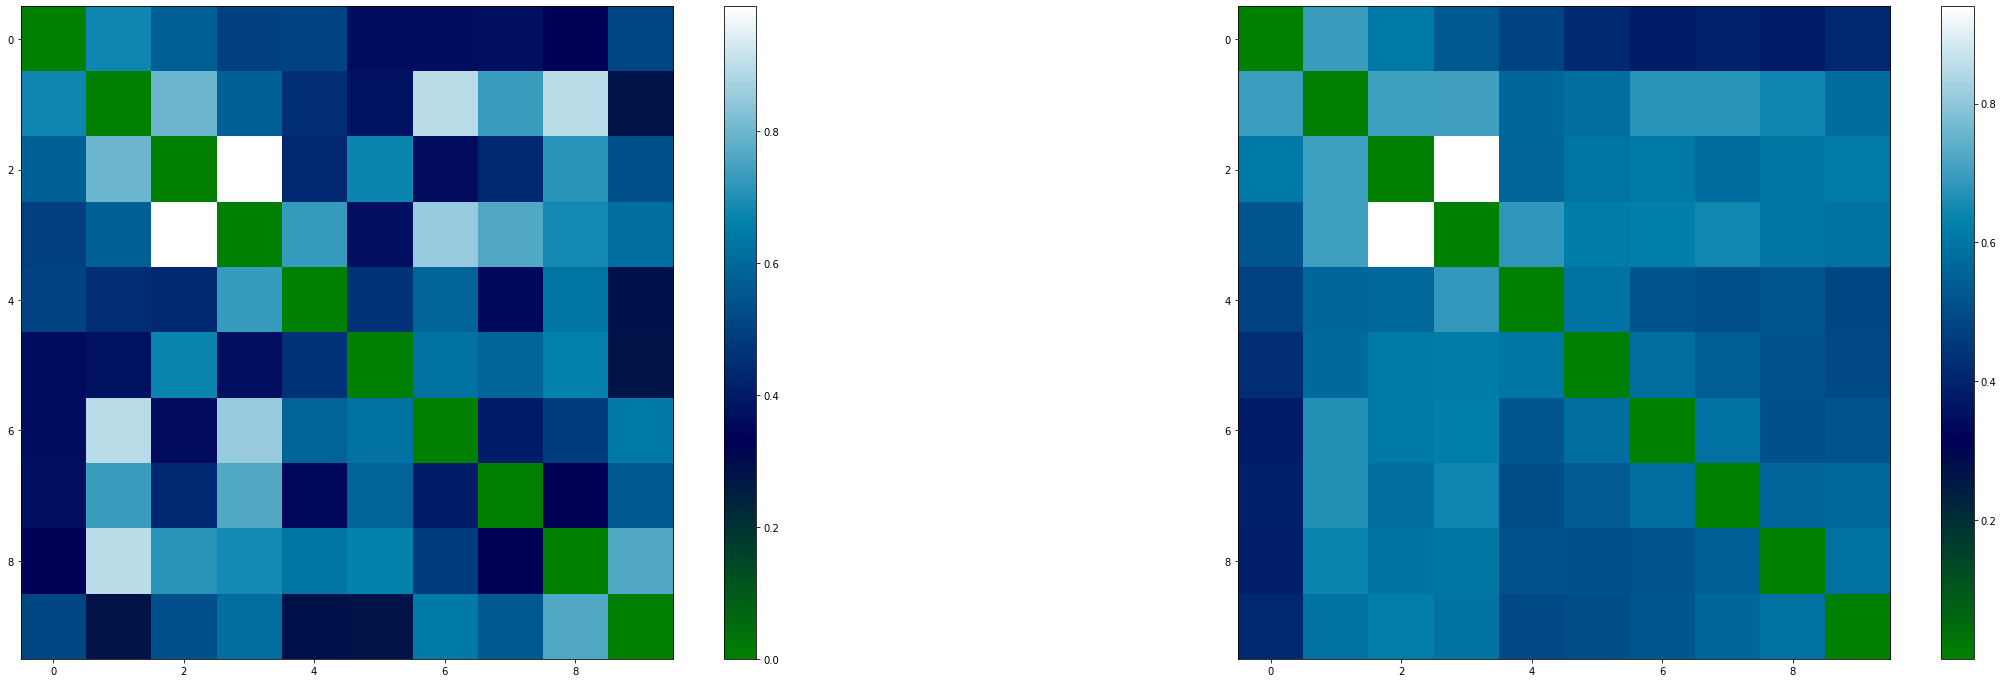

In [308]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
plt.imshow(x_test_flatten[1].reshape(X_train.shape[1],X_train.shape[2])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()

ax = fig.add_subplot(1,2,2)
ax.set_aspect('equal')
plt.imshow(predicted[1].reshape(X_train.shape[1],X_train.shape[2])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [309]:
np.mean(x_test_flatten[2])

0.45985544

In [310]:
np.mean(predicted[2])

0.4621712

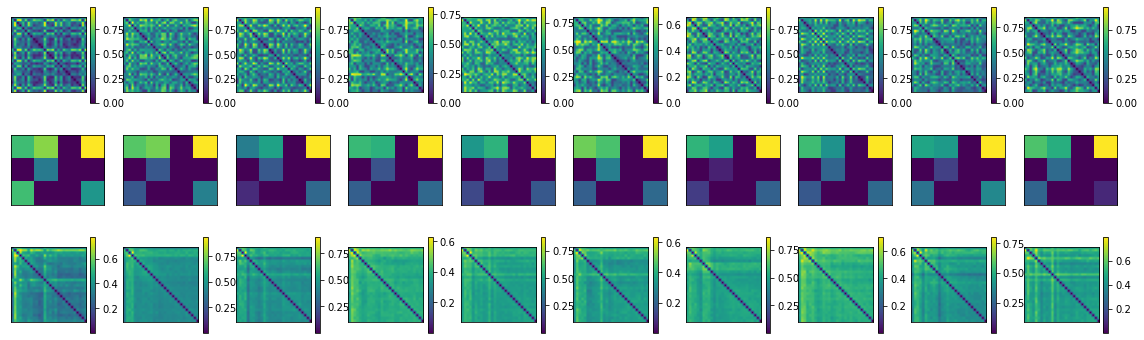

In [311]:
plt.figure(figsize=(40, 6))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_flatten[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(3,4))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Prueba

In [297]:
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64')
!pwd

/content/drive/.shortcut-targets-by-id/1asBEAN-S2b77S-W1swprmpEcUXwsqzS3/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64


In [298]:
chair = read_pc_by_class(2, 1024, 'chair', '../../data/modelnet40_normal_resampled')

In [299]:
def rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta), 0],
                     [np.sin(theta),np.cos(theta), 0],
                     [0,0,1]])

In [103]:
point_cloud_A = chair[0]
Rm = rotation_matrix(np.pi/2)
point_cloud_B= np.dot(Rm, chair[0].T).T


In [104]:
import tensorflow.compat.v1 as tf

In [105]:
DistAB, DistBA, DPDistAB=DPDist(point_cloud_A, point_cloud_B)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [106]:
def dpdist2dataframe(pcA, pcB, DistAB, DistBA):
  import pandas as pd
  datos = {'n_punto_pcA':range(pcA.shape[0]), 'Superficie_sB': range(pcB.shape[0]), 'DPDistAB': DistAB}
  datos2 = {'n_punto_pcB':range(pcB.shape[0]), 'Superficie_sA': range(pcA.shape[0]), 'DPDistBA': DistBA}
  d = pd.DataFrame(datos)
  d2 = pd.DataFrame(datos2)
  return d, d2

In [114]:
DistAB = DistAB[:,0]
DistBA = DistBA[:,0]

In [115]:
dataAB, dataBA = dpdist2dataframe(point_cloud_A, point_cloud_A, DistAB, DistBA)

In [116]:
def similares_diferentes(dataset1, dataset2, rango, pcA, pcB):
  
  m = dataset1
  m2= dataset2
  rango=rango
  similares=[]
  diferentes=[]
  sim = []
  dif = []
  
  for i in range(len(m['DPDistAB'])):
    if(m['DPDistAB'][i]<=rango):
      similares.append(m['n_punto_pcA'][i])
      sim.append(pcB[i])
    else:
      diferentes.append(m['n_punto_pcA'][i])
      dif.append(pcB[i])


  similares2=[]
  diferentes2=[]
  sim2 = []
  dif2 = []

  for i in range(len(m2['DPDistBA'])):
    if(m2['DPDistBA'][i]<=rango):
      similares2.append(m2['n_punto_pcB'][i])
      sim2.append(pcA[i])
    else:
      diferentes2.append(m2['n_punto_pcB'][i])
      dif2.append(pcA[i])
  
  similaresAB=similares
  diferentesAB=diferentes
  similaresBA=similares2
  diferentesBA=diferentes2

  simAB=sim
  difAB=dif
  simBA=sim2
  difBA=dif2

  return similaresAB, diferentesAB, similaresBA, diferentesBA, simAB, difAB, simBA, difBA 

In [117]:
similaresAB, diferentesAB, similaresBA, diferentesBA, simAB, difAB, simBA, difBA = similares_diferentes(dataAB, dataBA, 0.15,point_cloud_A,point_cloud_B)

In [118]:
def p_coincidentes_PcAyPcB(similaresAB, similaresBA):
  coincidentes=[]
  similares = similaresAB
  similares2 = similaresBA
  if len(similares)<len(similares2):
    for i in range(len(similares)):
      for j in range(len(similares)):
        if(similares[i]==similares2[j]):
          coincidentes.append(similares[i])
  else:
    for i in range(len(similares2)):
      for j in range(len(similares2)):
        if(similares2[i]==similares[j]):
          coincidentes.append(similares2[i])
  
  return coincidentes

In [119]:
coincidentes = p_coincidentes_PcAyPcB(similaresAB, similaresBA)

In [120]:
def distanciaEuclideana(pcA, pcB, posiciones_coincidentes):
  from scipy.spatial import distance

  pcAsim = []
  pcBsim = []
  for i in range(len(posiciones_coincidentes)):
    for j in range(len(pcA)):
      if(j==posiciones_coincidentes[i]):
        pcBsim.append(pcB[j])
        pcAsim.append(pcA[j])
  
  pcAnueva = np.array(pcAsim)
  pcBnueva = np.array(pcBsim)

  ematrix=np.ones((pcAnueva.shape[0],pcAnueva.shape[0]))
  for i in range(len(pcAnueva)):
    for j in range(len(pcBnueva)):
      dst = distance.euclidean(pcAnueva[i], pcBnueva[j])
      ematrix[i][j]=dst

  return pcAnueva, pcBnueva, ematrix

In [324]:
pcAnueva, pcBnueva, ematrix= distanciaEuclideana(point_cloud_A, point_cloud_B, coincidentes)

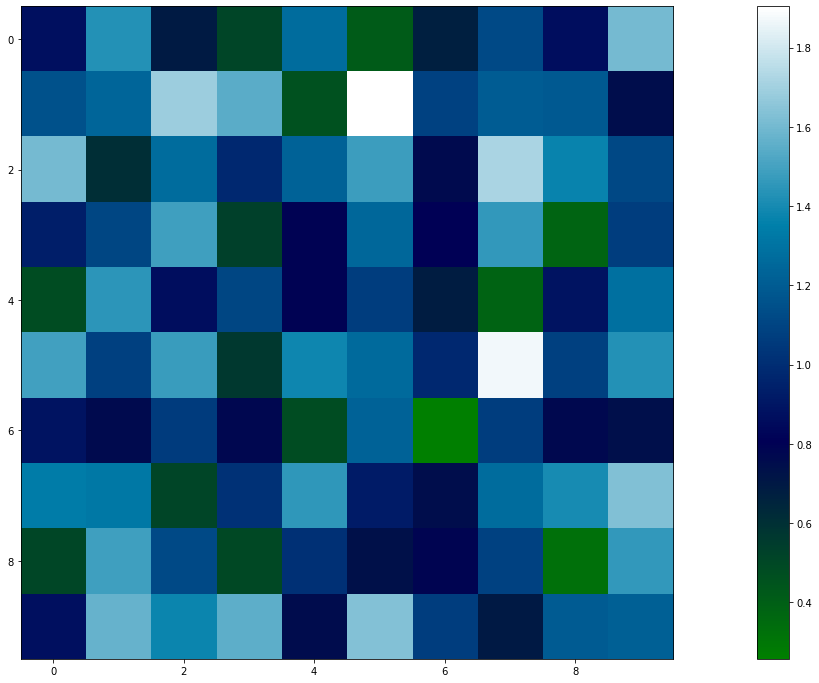

In [325]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(ematrix[:10,:10], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [326]:
ematrixs = ematrix[:28, :28]

In [327]:
ematrixflatten = ematrixs.reshape(1, ematrixs.shape[0]*ematrixs.shape[1])

In [328]:
ematrixflatten.shape

(1, 784)

In [329]:
bn = encoder.predict(ematrixflatten)
predicted = autoencoder.predict(ematrixflatten)
predicted.shape

(1, 784)

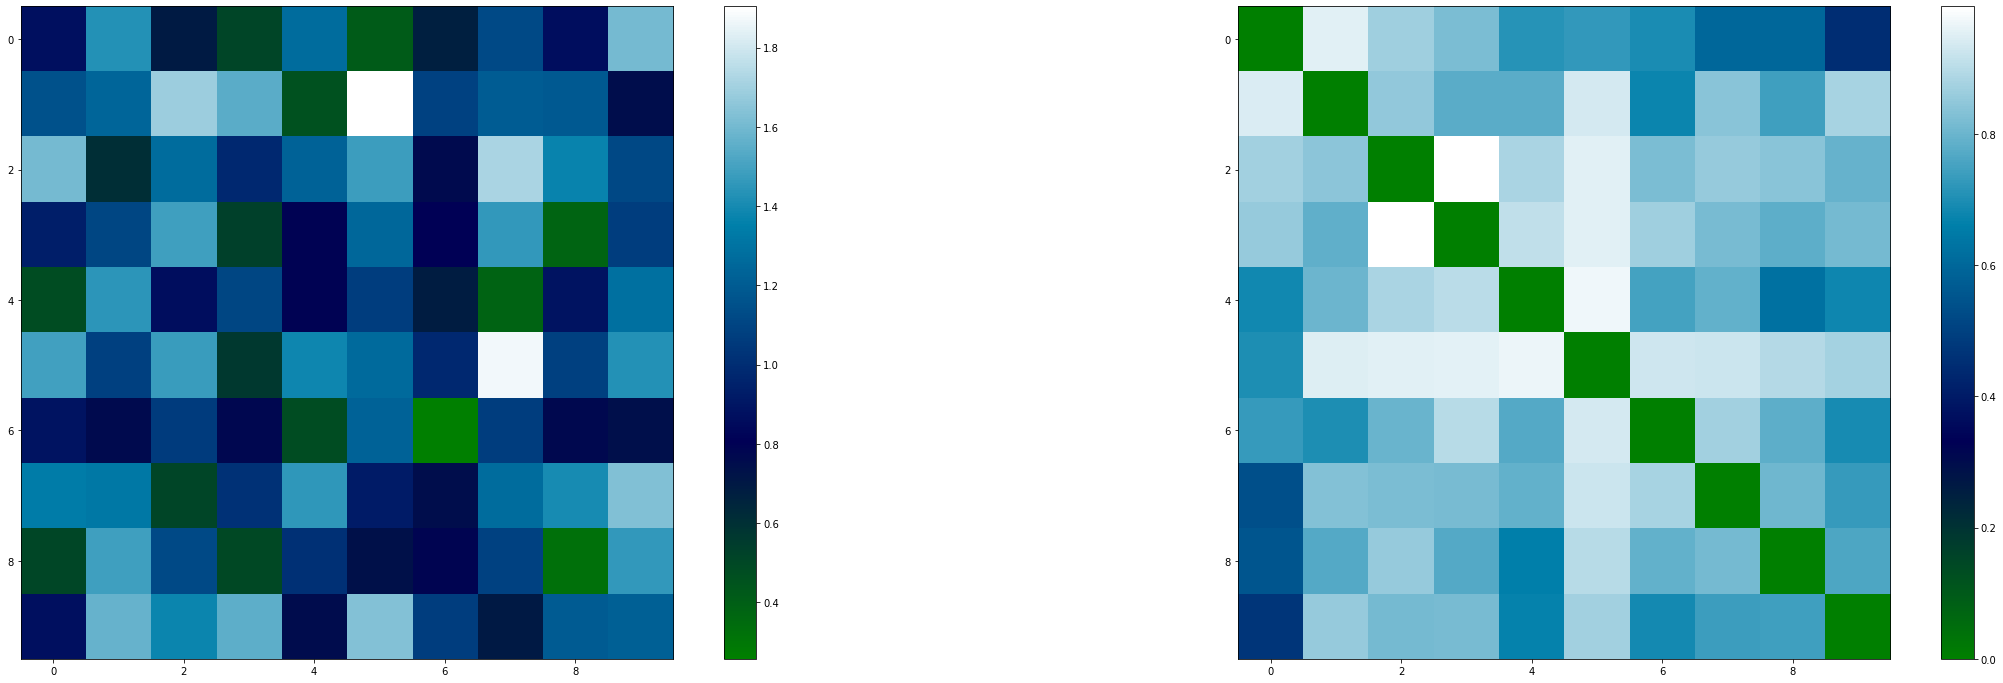

In [330]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
plt.imshow(ematrixflatten.reshape(ematrixs.shape[0],ematrixs.shape[1])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()

ax = fig.add_subplot(1,2,2)
ax.set_aspect('equal')
plt.imshow(predicted.reshape(ematrixs.shape[0],ematrixs.shape[1])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [331]:
pred = predicted.reshape(ematrixs.shape[0],ematrixs.shape[1])

In [332]:
print(bn.reshape(3,4))

[[ 9.020859   8.803026  -1.        17.944426 ]
 [-1.         2.2210944 -1.        -1.       ]
 [ 4.507399  -1.        -1.         4.931386 ]]


In [333]:

U, S, Vt = np.linalg.svd(pred) #cualquier transformación puede considerarse como una secuencia de rotación (V * ), escala (S) y rotación de nuevo (U)
R = np.dot(Vt.T, U.T) #matriz de rotación

In [334]:
R.shape

(28, 28)

In [335]:
f = [0,0,0,1]
f = np.array(f)
f.shape

(4,)

In [336]:
bn = bn.reshape(3,4)
bn.shape

(3, 4)

In [337]:
T = np.vstack([bn, f])

In [338]:
T

array([[ 9.02085876,  8.8030262 , -1.        , 17.94442558],
       [-1.        ,  2.22109437, -1.        , -1.        ],
       [ 4.50739908, -1.        , -1.        ,  4.93138599],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [339]:
Tmp = point_cloud_B[:,:3] + T[3,:3]
Tmp = np.dot(T[:3,:3],Tmp.T).T

In [340]:
Tmp.shape

(1024, 3)

Text(0.5, 0, 'Z')

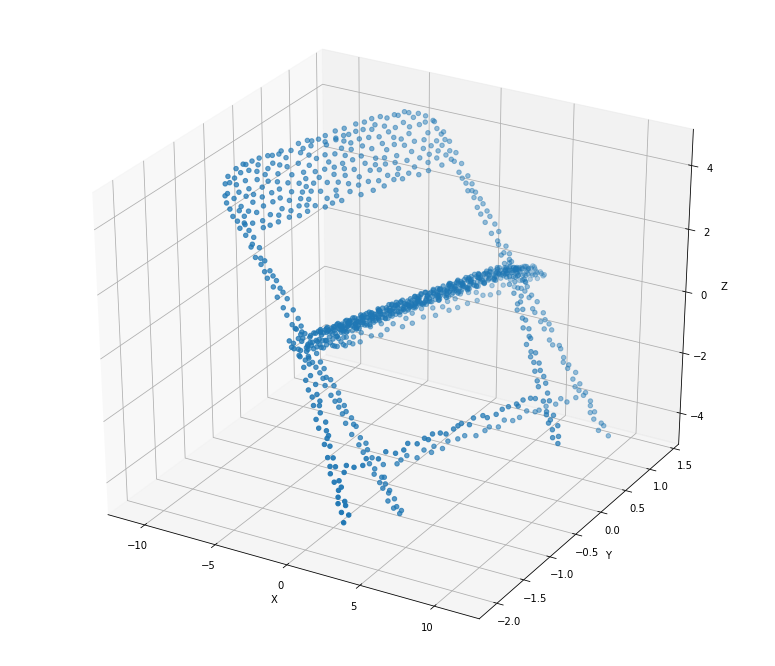

In [341]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = Tmp[:,0]
Y = Tmp[:,1]
Z = Tmp[:,2]
ax.scatter3D(X, Y, -Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

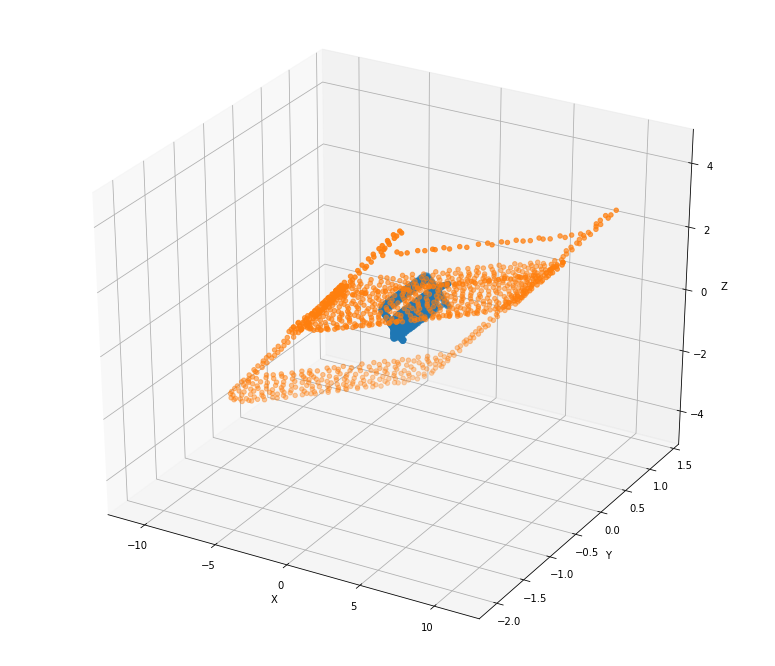

In [342]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloud_B[:,0]
Y = point_cloud_B[:,1]
Z = point_cloud_B[:,2]
ax.scatter3D(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
X = Tmp[:,0]
Y = Tmp[:,1]
Z = Tmp[:,2]
ax.scatter3D(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Autoencoder convolucional

In [138]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1) ) 
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x) #  (4, 4, 8)  128-dimensional
x = tf.keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = tf.keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_cnn = tf.keras.models.Model(input_img, decoded)

autoencoder_cnn.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 7, 7, 8)           584

In [139]:
import tensorflow as tf

In [140]:
opt = tf.optimizers.Adamax(learning_rate = 0.01)
autoencoder_cnn.compile(optimizer=opt, loss='binary_crossentropy')
hist = autoencoder_cnn.fit(x_train_d, x_train_d, epochs=50,
                  batch_size=16, shuffle=True,
                  validation_data=(x_test_d, x_test_d))

Train on 3308 samples, validate on 828 samples
Epoch 1/50
3308/3308 [==============================] - ETA: 0s - loss: 0.6822

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3308/3308 [==============================] - 9s 3ms/sample - loss: 0.6822 - val_loss: 0.6734
Epoch 2/50
3308/3308 [==============================] - 8s 3ms/sample - loss: 0.6727 - val_loss: 0.6652
Epoch 3/50
3308/3308 [==============================] - 8s 2ms/sample - loss: 0.6632 - val_loss: 0.6586
Epoch 4/50
3308/3308 [==============================] - 8s 3ms/sample - loss: 0.6606 - val_loss: 0.6575
Epoch 5/50
3308/3308 [==============================] - 9s 3ms/sample - loss: 0.6595 - val_loss: 0.6563
Epoch 6/50
3308/3308 [==============================] - 9s 3ms/sample - loss: 0.6587 - val_loss: 0.6567
Epoch 7/50
3308/3308 [==============================] - 8s 3ms/sample - loss: 0.6580 - val_loss: 0.6552
Epoch 8/50
3308/3308 [==============================] - 9s 3ms/sample - loss: 0.6575 - val_loss: 0.6545
Epoch 9/50
3308/3308 [==============================] - 9s 3ms/sample - loss: 0.6571 - val_loss: 0.6552
Epoch 10/50
3308/3308 [==============================] - 9s 3ms/sample - lo

In [141]:
# Encoder
encoder = tf.keras.models.Model(input_img, encoded)

encoded_imgs = encoder.predict(x_test_d)
predicted = autoencoder_cnn.predict(x_test_d)
predicted.shape

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(828, 28, 28, 1)

In [142]:

encoded_imgs.shape

(828, 2, 2, 3)

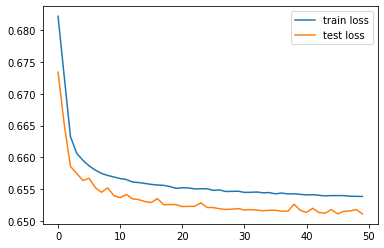

In [143]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

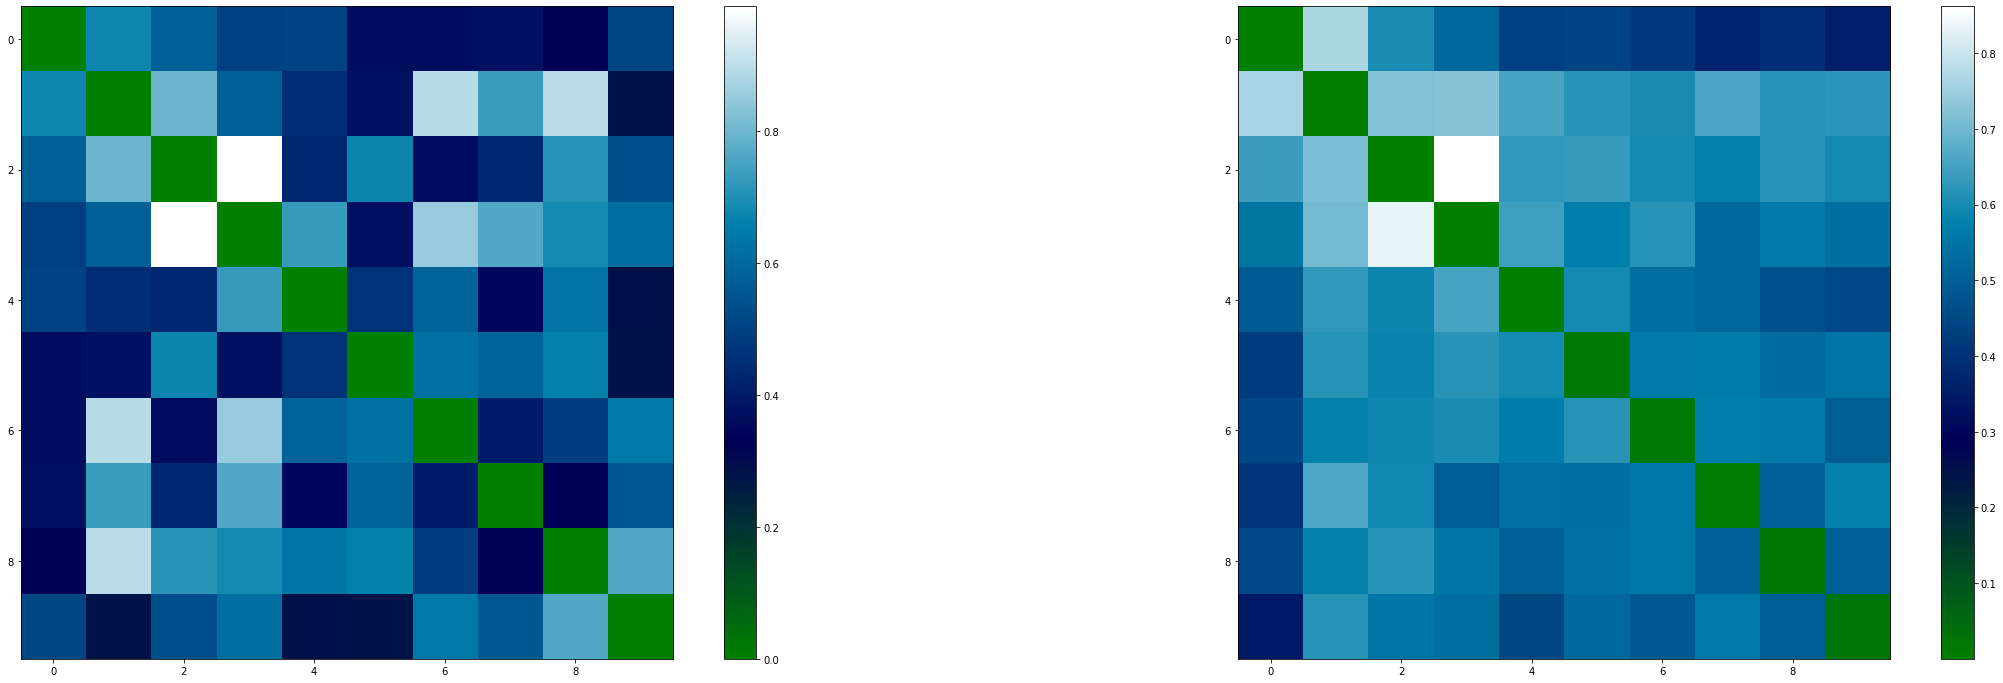

In [144]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
plt.imshow(x_test_flatten[1].reshape(X_train.shape[1],X_train.shape[2])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()

ax = fig.add_subplot(1,2,2)
ax.set_aspect('equal')
plt.imshow(predicted[1].reshape(X_train.shape[1],X_train.shape[2])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

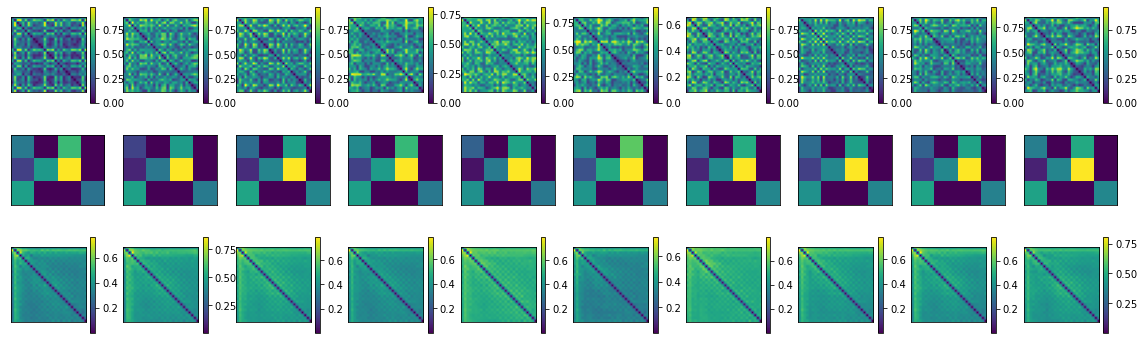

In [146]:
plt.figure(figsize=(40, 6))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_flatten[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(3,4))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Prueba

In [147]:
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64')
!pwd

/content/drive/.shortcut-targets-by-id/1asBEAN-S2b77S-W1swprmpEcUXwsqzS3/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64


In [148]:
chair = read_pc_by_class(2, 1024, 'chair', '../../data/modelnet40_normal_resampled')

In [149]:
def rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta), 0],
                     [np.sin(theta),np.cos(theta), 0],
                     [0,0,1]])

In [150]:
point_cloud_A = chair[0]
Rm = rotation_matrix(np.pi/2)
point_cloud_B= np.dot(Rm, chair[0].T).T


In [151]:
import tensorflow.compat.v1 as tf

In [152]:
DistAB, DistBA, DPDistAB=DPDist(point_cloud_A, point_cloud_B)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [153]:
def dpdist2dataframe(pcA, pcB, DistAB, DistBA):
  import pandas as pd
  datos = {'n_punto_pcA':range(pcA.shape[0]), 'Superficie_sB': range(pcB.shape[0]), 'DPDistAB': DistAB}
  datos2 = {'n_punto_pcB':range(pcB.shape[0]), 'Superficie_sA': range(pcA.shape[0]), 'DPDistBA': DistBA}
  d = pd.DataFrame(datos)
  d2 = pd.DataFrame(datos2)
  return d, d2

In [155]:
dataAB, dataBA = dpdist2dataframe(point_cloud_A, point_cloud_A, DistAB[:,0], DistBA[:,0])

In [156]:
def similares_diferentes(dataset1, dataset2, rango, pcA, pcB):
  
  m = dataset1
  m2= dataset2
  rango=rango
  similares=[]
  diferentes=[]
  sim = []
  dif = []
  
  for i in range(len(m['DPDistAB'])):
    if(m['DPDistAB'][i]<=rango):
      similares.append(m['n_punto_pcA'][i])
      sim.append(pcB[i])
    else:
      diferentes.append(m['n_punto_pcA'][i])
      dif.append(pcB[i])


  similares2=[]
  diferentes2=[]
  sim2 = []
  dif2 = []

  for i in range(len(m2['DPDistBA'])):
    if(m2['DPDistBA'][i]<=rango):
      similares2.append(m2['n_punto_pcB'][i])
      sim2.append(pcA[i])
    else:
      diferentes2.append(m2['n_punto_pcB'][i])
      dif2.append(pcA[i])
  
  similaresAB=similares
  diferentesAB=diferentes
  similaresBA=similares2
  diferentesBA=diferentes2

  simAB=sim
  difAB=dif
  simBA=sim2
  difBA=dif2

  return similaresAB, diferentesAB, similaresBA, diferentesBA, simAB, difAB, simBA, difBA 

In [157]:
similaresAB, diferentesAB, similaresBA, diferentesBA, simAB, difAB, simBA, difBA = similares_diferentes(dataAB, dataBA, 0.15,point_cloud_A,point_cloud_B)

In [158]:
def p_coincidentes_PcAyPcB(similaresAB, similaresBA):
  coincidentes=[]
  similares = similaresAB
  similares2 = similaresBA
  if len(similares)<len(similares2):
    for i in range(len(similares)):
      for j in range(len(similares)):
        if(similares[i]==similares2[j]):
          coincidentes.append(similares[i])
  else:
    for i in range(len(similares2)):
      for j in range(len(similares2)):
        if(similares2[i]==similares[j]):
          coincidentes.append(similares2[i])
  
  return coincidentes

In [159]:
coincidentes = p_coincidentes_PcAyPcB(similaresAB, similaresBA)

In [160]:
def distanciaEuclideana(pcA, pcB, posiciones_coincidentes):
  from scipy.spatial import distance

  pcAsim = []
  pcBsim = []
  for i in range(len(posiciones_coincidentes)):
    for j in range(len(pcA)):
      if(j==posiciones_coincidentes[i]):
        pcBsim.append(pcB[j])
        pcAsim.append(pcA[j])
  
  pcAnueva = np.array(pcAsim)
  pcBnueva = np.array(pcBsim)

  ematrix=np.ones((pcAnueva.shape[0],pcAnueva.shape[0]))
  for i in range(len(pcAnueva)):
    for j in range(len(pcBnueva)):
      dst = distance.euclidean(pcAnueva[i], pcBnueva[j])
      ematrix[i][j]=dst

  return pcAnueva, pcBnueva, ematrix

In [161]:
pcAnueva, pcBnueva, ematrix= distanciaEuclideana(point_cloud_A, point_cloud_B, coincidentes)

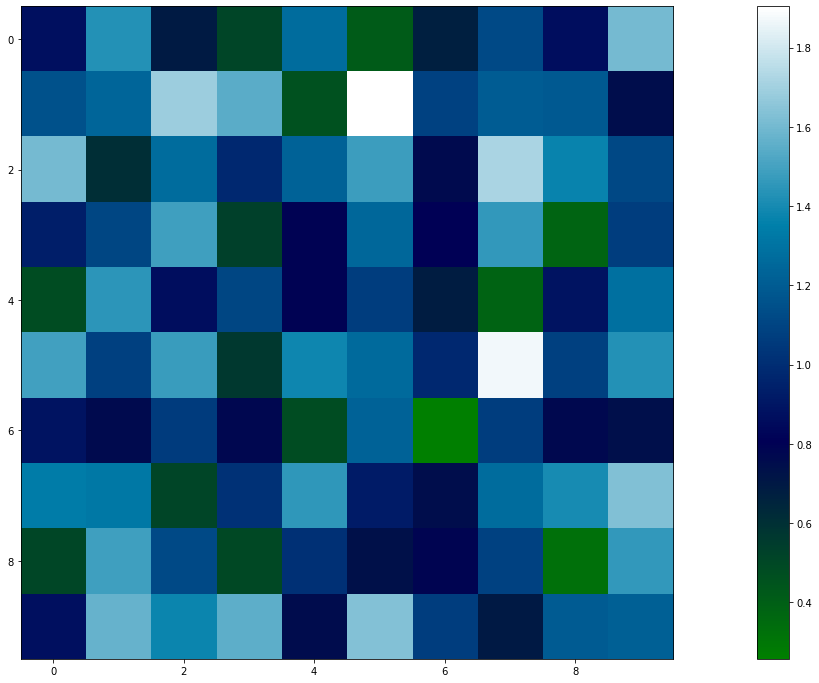

In [162]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(ematrix[:10,:10], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [167]:
ematrixs = ematrix[:28, :28]

In [171]:
ematrixs.shape[0]

28

In [180]:
ematrixflatten = ematrixs.reshape(1, ematrixs.shape[0],ematrixs.shape[1], 1)

In [181]:
ematrixflatten.shape

(1, 28, 28, 1)

In [182]:
x_test_d[0].shape

(28, 28, 1)

In [184]:
bn = encoder.predict(ematrixflatten)
predicted = autoencoder_cnn.predict(ematrixflatten)
predicted.shape

(1, 28, 28, 1)

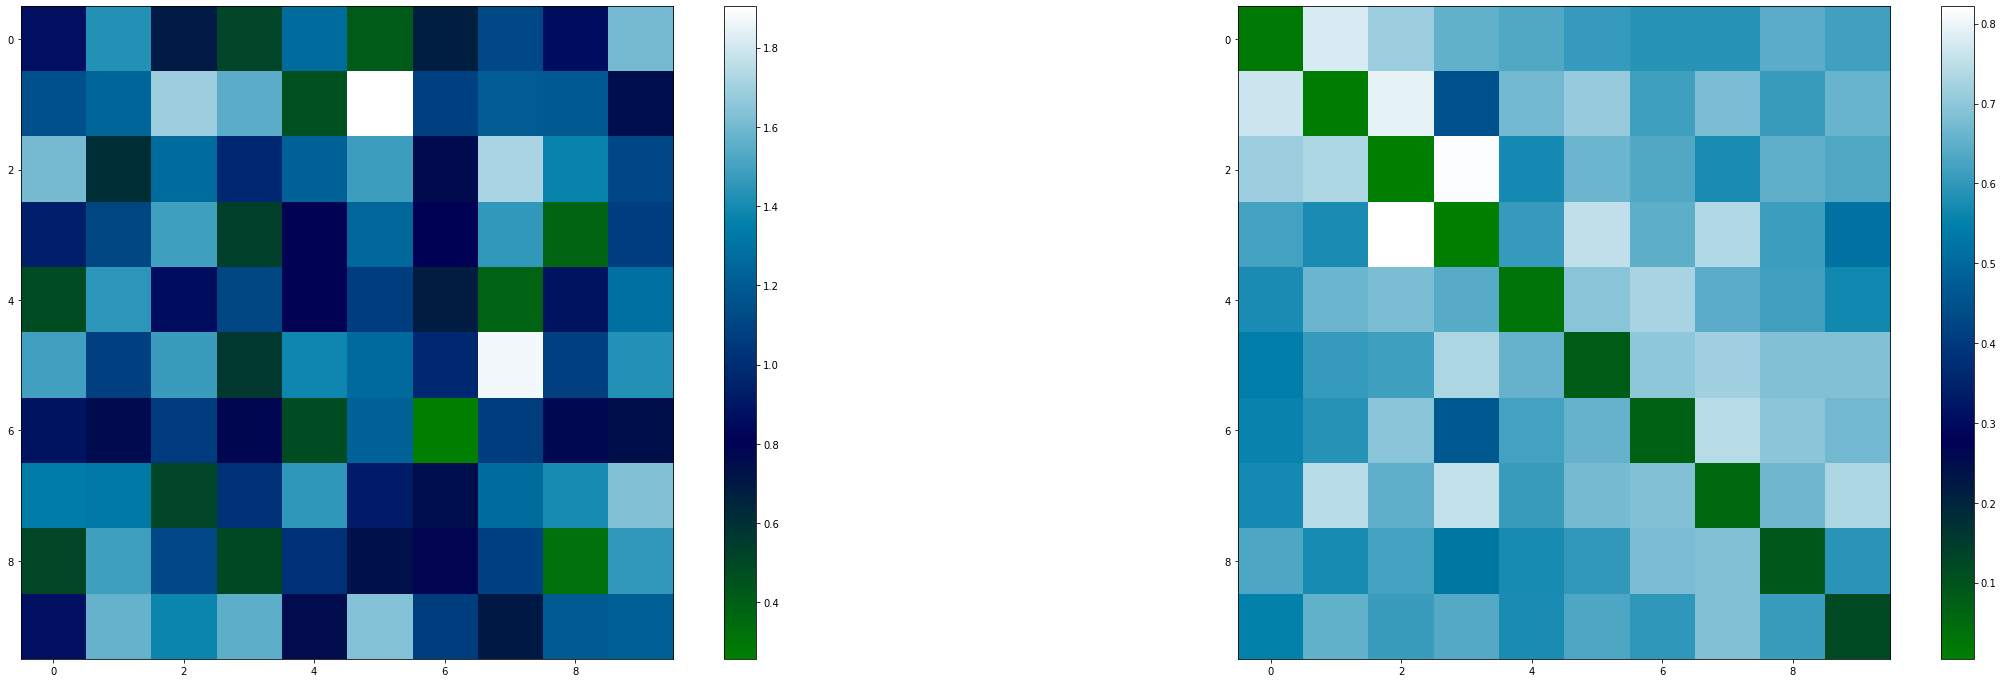

In [185]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
plt.imshow(ematrixflatten.reshape(ematrixs.shape[0],ematrixs.shape[1])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()

ax = fig.add_subplot(1,2,2)
ax.set_aspect('equal')
plt.imshow(predicted.reshape(ematrixs.shape[0],ematrixs.shape[1])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [186]:
pred = predicted.reshape(ematrixs.shape[0],ematrixs.shape[1])

In [210]:
print(bn.reshape(3,4))

[[0.3235502  0.02347431 0.6178184  0.23407924]
 [0.         0.49307787 1.484767   0.        ]
 [0.7762421  0.01889521 0.         0.41858983]]


In [211]:

U, S, Vt = np.linalg.svd(pred) #cualquier transformación puede considerarse como una secuencia de rotación (V * ), escala (S) y rotación de nuevo (U)
R = np.dot(Vt.T, U.T) #matriz de rotación

In [212]:
R.shape

(28, 28)

In [213]:
f = [0,0,0,1]
f = np.array(f)
f.shape

(4,)

In [214]:
bn = bn.reshape(3,4)
bn.shape

(3, 4)

In [215]:
T = np.vstack([bn, f])

In [216]:
T

array([[0.32355019, 0.02347431, 0.61781842, 0.23407924],
       [0.        , 0.49307787, 1.48476696, 0.        ],
       [0.77624208, 0.01889521, 0.        , 0.41858983],
       [0.        , 0.        , 0.        , 1.        ]])

In [217]:
Tmp = point_cloud_B[:,:3] + T[3,:3]
Tmp = np.dot(T[:3,:3],Tmp.T).T

In [218]:
Tmp.shape

(1024, 3)

Text(0.5, 0, 'Z')

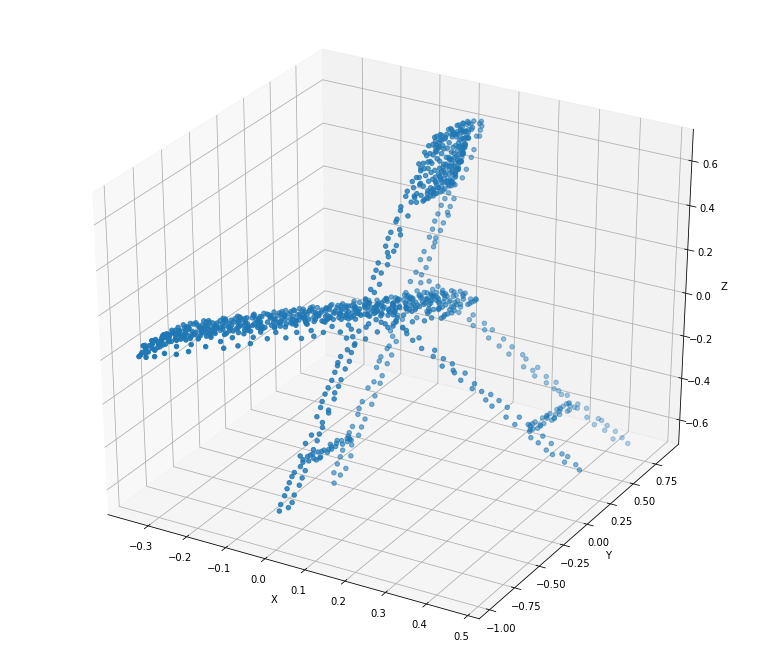

In [222]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = Tmp[:,0]
Y = Tmp[:,1]
Z = Tmp[:,2]
ax.scatter3D(X, Y, -Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

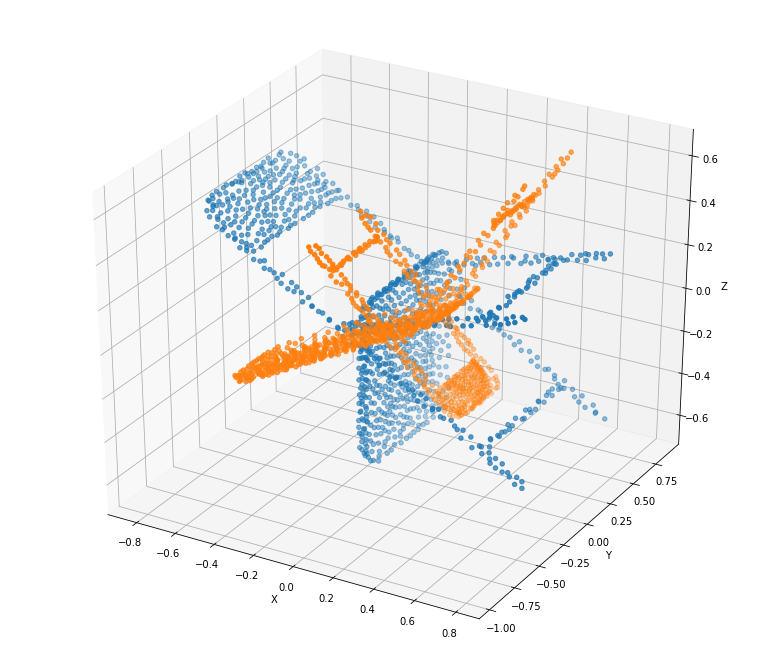

In [223]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = point_cloud_B[:,0]
Y = point_cloud_B[:,1]
Z = point_cloud_B[:,2]
ax.scatter3D(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
X = Tmp[:,0]
Y = Tmp[:,1]
Z = Tmp[:,2]
ax.scatter3D(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

#Autoencoder flatten con activacion sigmoide 256x256




In [ ]:
ematrixs = ematrixs
ematrixs.shape

In [ ]:
ematrixs.shape

In [ ]:
X = np.array(ematrix_list_new)
print(X.shape)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
X_train = X_train.astype('float32') / np.max(X_train)
X_test = X_test.astype('float32') / np.max(X_test)


In [ ]:
x_train_flatten = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
x_test_flatten = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
#y_train_flatten = Y_train.reshape(len(Y_train), np.prod(Y_train.shape[1:]))
#y_test_flatten = Y_test.reshape(len(Y_test), np.prod(Y_test.shape[1:]))
print(x_train_flatten.shape)
#print(y_train_flatten.shape)

In [ ]:
encoding_dimension = 32
input_img = tf.keras.layers.Input(shape=(x_train_flatten.shape[1],))
#encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(encoding_dimension, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
#decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(x_train_flatten.shape[1], activation='sigmoid')(decoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.summary()

In [ ]:
import tensorflow as tf

In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.01)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
hist = autoencoder.fit(x_train_flatten, x_train_flatten, epochs=50,
                batch_size=16, 
                shuffle=True,
                validation_data=(x_train_flatten, x_train_flatten))

In [ ]:

# Encoder
encoder = tf.keras.models.Model(input_img, encoded)

'''
#Decoder
encoded_input = tf.keras.layers.Input(shape=(encoding_dimension,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

print("\n encoder model: encoder \n")
print(encoder.summary())
print(" \n decoder model: decoder \n")
print(decoder.summary())
'''

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

In [ ]:
encoded_imgs = encoder.predict(x_test_flatten)
predicted = autoencoder.predict(x_test_flatten)
predicted.shape

In [ ]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
plt.imshow(x_test_flatten[2].reshape(X_train.shape[1],X_train.shape[2])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()

ax = fig.add_subplot(1,2,2)
ax.set_aspect('equal')
plt.imshow(predicted[2].reshape(X_train.shape[1],X_train.shape[2])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_flatten[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(4,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Autoencoder flatten sin activacion sigmoide

In [ ]:
ematrixs = ematrixs
ematrixs.shape

In [ ]:
ematrixs.shape

In [ ]:
X = np.array(ematrix_list_new)
print(X.shape)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
X_train = X_train.astype('float32') / np.max(X_train)
X_test = X_test.astype('float32') / np.max(X_test)


In [ ]:
x_train_flatten = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
x_test_flatten = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
#y_train_flatten = Y_train.reshape(len(Y_train), np.prod(Y_train.shape[1:]))
#y_test_flatten = Y_test.reshape(len(Y_test), np.prod(Y_test.shape[1:]))
print(x_train_flatten.shape)
#print(y_train_flatten.shape)

In [ ]:
encoding_dimension = 32
input_img = tf.keras.layers.Input(shape=(x_train_flatten.shape[1],))
#encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)

encoded = tf.keras.layers.Dense(encoding_dimension, activation='relu')(input_img)

#decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(x_train_flatten.shape[1], activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.summary()

In [ ]:
import tensorflow as tf

In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.01)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
hist = autoencoder.fit(x_train_flatten, x_train_flatten, epochs=50,
                batch_size=256, shuffle=True,
                validation_data=(x_train_flatten, x_train_flatten))

In [ ]:

# Encoder
encoder = tf.keras.models.Model(input_img, encoded)


#Decoder
encoded_input = tf.keras.layers.Input(shape=(encoding_dimension,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

print("\n encoder model: encoder \n")
print(encoder.summary())
print(" \n decoder model: decoder \n")
print(decoder.summary())


In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss');
plt.plot(hist.history['val_loss'], label='test loss');
plt.legend()
plt.show();

In [ ]:
encoded_imgs = encoder.predict(x_test_flatten)
predicted = autoencoder.predict(x_test_flatten)
predicted.shape

In [ ]:
fig = plt.figure(figsize=(40,12))

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal')
plt.imshow(x_test_flatten[2].reshape(X_train.shape[1],X_train.shape[2])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()

ax = fig.add_subplot(1,2,2)
ax.set_aspect('equal')
plt.imshow(predicted[2].reshape(X_train.shape[1],X_train.shape[2])[0:10,0:10], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_flatten[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(4,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(X_train.shape[1], X_train.shape[2]))
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#Prueba aleatoria

In [ ]:
index_image =  15
random_index =  5
exp_orig = np.expand_dims(encoded_imgs[index_image], axis=0)
random_h = (np.random.random(encoded_imgs[index_image].shape))*random_index
exp_rand = np.expand_dims(random_h, axis=0)


In [ ]:
decod_img = decoder.predict(exp_orig)
decod_rnd = decoder.predict(exp_rand)

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(exp_rand.reshape(4,8))


In [ ]:


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(decod_img.reshape(64,64)[0:10,0:10])
ax = fig.add_subplot(2, 2, 2)
ax.imshow(decod_rnd.reshape(64,64)[0:10,0:10])
ax = fig.add_subplot(2, 2, 3)
ax.imshow(encoded_imgs[index_image].reshape(4,8))
ax = fig.add_subplot(2, 2, 4)
ax.imshow(random_h.reshape(4,8))



In [ ]:
plt.figure(figsize=(60, 10))
# display original
ax = plt.subplot(1, 3, 1)
plt.imshow(x_test_flatten[1].reshape(X.shape[1], X.shape[2])[:10,:10], cmap=plt.cm.ocean)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.colorbar()
# display encoded image
ax = plt.subplot(1, 3, 2)
plt.imshow(encoded_imgs[1].reshape(8,4))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# display reconstruction
ax = plt.subplot(1, 3, 3)
plt.imshow(predicted[1].reshape(X.shape[1],X.shape[2])[:10,:10], cmap=plt.cm.ocean)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.colorbar()

In [ ]:
import random
random.shuffle(edist)

In [ ]:
edist[0:10]

In [ ]:
dif = np.array(dif)

In [ ]:
sim = np.array(sim)

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 4, 1, projection='3d')
X = pcA[:,0]
Y = pcA [:,1]
Z = pcA[:,2]
ax.scatter3D(-Z,X,Y)
ax.set_xlabel('-Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')


ax = fig.add_subplot(1, 4, 2, projection='3d')
X = pcB[:,0]
Y = pcB [:,1]
Z = pcB[:,2]
ax.scatter3D(-Z,X,Y)
ax.set_xlabel('-Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')


ax = fig.add_subplot(1, 4, 3, projection='3d')
X = sim[:,0]
Y = sim [:,1]
Z = sim[:,2]
ax.scatter3D(-Z,X,Y, c='green')
ax.set_xlabel('-Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')


ax = fig.add_subplot(1, 4, 4, projection='3d')
X = dif[:,0]
Y = dif [:,1]
Z = dif[:,2]
ax.scatter3D(-Z,X,Y, c='red')
ax.set_xlabel('-Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')
plt.show()


In [ ]:
range(len(similares))

In [ ]:
round(len(X_train)*0.80)

In [ ]:
Data = np.array(edist)
X_train = Data[0:round(len(Data)*0.80)]
X_test = Data[round(len(Data)*0.80):]

In [ ]:
X_train.shape

In [ ]:
X_test=X_test.reshape(X_test.shape[0],-1)

In [ ]:
X_train=X_train.reshape(X_train.shape[0],-1)

In [ ]:
X_train.shape

In [ ]:
encoding_dimension = 32
input_img = tf.keras.layers.Input(shape=(1,))
encoded = tf.keras.layers.Dense(encoding_dimension, activation='relu')(input_img)
#decoded = tf.keras.layers.Dense(693, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, encoded)
autoencoder.summary()


In [ ]:
input_img 

In [ ]:
import tensorflow as tf


In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.01)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=70,
                batch_size=256, shuffle=True,
                validation_data=(X_test, X_test))

In [ ]:
models = models.reshape(63504, 1024, 3)

models[0].shape

DpdistList = []

In [ ]:
fig = plt.figure(figsize=(30,12))


ax = fig.add_subplot(1, 3, 1, projection='3d')
X = models[0] [:,0]
Y = models[0] [:,1]
Z = models[0] [:,2]

ax.scatter3D(Z,X,Y)
ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')





ax = fig.add_subplot(1, 3, 3, projection='3d')
X = models[10] [:,0]
Y = models[10] [:,1]
Z = models[10] [:,2]
ax.scatter3D(-Z,X,Y)
ax.set_xlabel('-Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')

plt.show()

In [ ]:
for i in range(20):
  DistAB, DistBA, DPDistAB=DPDist(models[0], models[i])
  DpdistList.append(DPDistAB) 

In [ ]:
DistAB, DistBA, DPDistAB=DPDist(models[0], models[10])

In [ ]:
DPDistAB

In [ ]:
DpdistList

In [ ]:
os.chdir('/content/drive/MyDrive/Proyecto de grado-Extensión/Registro de Nubes/Registro de Nubes')
!pwd

In [ ]:
pcA=np.loadtxt('../../data/airplane/airplane_0008.txt', delimiter=',', usecols=(0,1,2))
#pcB=np.loadtxt('././data/modelnet40_normal_resampled/airplane/airplane_0008.txt', delimiter=',', usecols=(0,1,2))

In [ ]:
os.chdir('/content/drive/MyDrive/Proyecto de grado-Extensión/Registro de Nubes')
!pwd

In [ ]:
angulosRotados = np.loadtxt('./resultadosDPDist/angulos_modelo_rotado1.txt', delimiter=',', usecols=(0,1,2))
distanciasModo1 = np.loadtxt('./resultadosDPDist/DPDist_distancias2.txt')
distanciasModo2 = np.loadtxt('./resultadosDPDist/DPDist_distancias3.txt')

In [ ]:
len(angulosRotados)
angulosRotados=angulosRotados[:100] #Tomo los 100 primeros angulos rotados en los modelos que hallamos el DPDist

In [ ]:
distanciasModo1

In [ ]:
fig = plt.figure(figsize=(30,12))


ax = fig.add_subplot(1, 3, 1)
X = range(100)
Y = distanciasModo1


ax.scatter(X,Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [ ]:
fig = plt.figure(figsize=(30,12))


ax = fig.add_subplot(1, 3, 1)
X = range(100)
Y = distanciasModo2


ax.scatter(X,Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [ ]:
print(angulosRotados[62:67])
print()
print(distanciasModo1[62:67])

In [ ]:
print(angulosRotados[:5])
print()
print(distanciasModo1[0:5])

In [ ]:
for i in range(len(distanciasModo1)):
  for j in range(len(distanciasModo1)):
    if (i != j):
      if (distanciasModo1[i]==distanciasModo1[j]):
        print("Hay dos datos iguales: " , distanciasModo1[i])
        break
      #else:
        #print("Son diferentes:" , distanciasModo1[i] , distanciasModo1[j])

In [ ]:
for i in range(len(distanciasModo2)):
  for j in range(len(distanciasModo2)):
    if (i != j):
      if (distanciasModo2[i]==distanciasModo2[j]):
        print("Hay dos datos iguales: " , distanciasModo2[i])
        break
      #else:
        #print("Son diferentes:" , distanciasModo2[i] , distanciasModo2[j])